# Kaggle Cycle Share: Synopsis of analysis

The full analysis can be found in the series of python files:

[https://github.com/ingonader/python-for-data-science-edx/tree/master/week-09-and-10-final-project](https://github.com/ingonader/python-for-data-science-edx/tree/master/week-09-and-10-final-project)

```
kgl-cycle-share-main-file.py
kgl-cycle-share-01-setup.py
kgl-cycle-share-02-data-download.py
kgl-cycle-share-03-data-load.py
kgl-cycle-share-04-data-prep.py
kgl-cycle-share-05-exploratory-analysis.py
kgl-cycle-share-06a-random-forest.py
kgl-cycle-share-06b-gradient-boosting-weather-only.py
kgl-cycle-share-06b-gradient-boosting-with-dewpoint.py
kgl-cycle-share-06b-gradient-boosting-with-imputation.py
kgl-cycle-share-06b-gradient-boosting.py
kgl-cycle-share-06c-xgboost.py
kgl-cycle-share-06d-pt01-classification-gb.py
kgl-cycle-share-06d-pt02-regression-gb.py
kgl-cycle-share-06d-pt03-combination.py
kgl-cycle-share-07-eval-model.py
```


## Setup

In [1]:
## ========================================================================= ## 
## import libraries
## ========================================================================= ##

import requests
import io
import zipfile
import os
import urllib.parse
import re   ## for regular expressions
from itertools import chain  ## for chain, similar to R's unlist (flatten lists)
import collections   ## for Counters (used in frequency tables, for example)
import numpy as np
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype  ## for sorted plotnine/ggplot categories
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns  ## for correlation heatmap
#from mpl_toolkits.basemap import Basemap
import folium
from scipy import stats

import patsy ## for design matrices like R
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

import pathvalidate as pv



## ========================================================================= ##
## global variables and options
## ========================================================================= ##

path_dat = './data'
path_out = './output'

pd.set_option('display.max_columns', 50)

## weather data: station_id, year_list, month_list for data download and data prep:

# station_id = 51157 # MONTREAL INTL A; QUEBEC 
station_id = 10761 # "MCTAVISH", "QUEBEC"
year_list = [2014, 2015, 2016, 2017]
month_list = list(range(1, 13))

## cycle trip data:

## data for these years:
dat_years = [2014, 2015, 2016, 2017]

## "translation" from "quoted" to long variable / feature names:
varnames_long_dict = {
    "Q('Month')" :              "Month (1-12)",
    "Q('Temp (°C)')" :          "Temperature (°C)",    
    "Q('Rel Hum (%)')" :        "Relative Humidity (%)",      
    "Q('Wind Dir (10s deg)')" : "Wind Direction (deg)",             
    "Q('Wind Spd (km/h)')" :    "Wind Speed (km/h)",          
    "Q('Stn Press (kPa)')" :    "Atmospheric Pressure (kPa)",          
    "Q('hr_of_day')" :          "Hour of the Day (0-23)",    
    "Q('day_of_week')" :         "Day of the Week (0-6)"
}

## "translation" of unquoted to long variable / feature names:
varnames_orig_long_dict = {
    'trip_cnt' 				: 'Trip Count',
    'Year' 					: 'Year (2014-2017)',
    'Month' 				: 'Month (1-12)',
    'Temp (°C)' 			: 'Temperature (°C)',
    'Dew Point Temp (°C)' 	: 'Dew Point (°C)',
    'Rel Hum (%)' 			: 'Relative Humidity (%)',
    'Wind Dir (10s deg)' 	: 'Wind Direction (10s deg)',
    'Wind Spd (km/h)'  		: 'Wind Speed (km/h)',
    'Stn Press (kPa)' 		: 'Atmospheric Pressure (kPa)',
    'hr_of_day' 			: 'Hour of the Day (0-23)',
    'day_of_week' 			: 'Day of the Week (0-6)'
}



/Users/ingonader/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Download

In [2]:
## ========================================================================= ##
## download data
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## montreal bike share data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## BIXI Montreal (public bicycle sharing system)
## Data on North America's first large-scale bike sharing system
## https://www.kaggle.com/aubertsigouin/biximtl/home

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## weather data from canadian government
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## station id available from:
## ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/
## ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/Station%20Inventory%20EN.csv

## define station, years and month:
## (for downloading and data prep later)
## see setup.py file

for year in year_list:
    for month in month_list:
        ## define url for bulk data download of http://climate.weather.gc.ca/climate_data :
        url_string = 'http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={0}&Year={1}&Month={2}&Day=14&timeframe=1&submit=Download+Data'.format(station_id, year, month)
        
        ## define filename, as well as target path:
        filename_target = 'weather_montreal_{0}_{1:04d}_{2:02d}.csv'.format(station_id, year, month)
        path_dat = './data'
        
        ## check if file exists, only download if it does not exist:
        if os.path.isfile(os.path.join(path_dat, filename_target)):
            print('year {0:04d}, month {1:02d} -- file exists, skipped.'.format(year, month))
        else:
            ## download (commented out in order not to repeat it every time):
            r = requests.get(url_string, allow_redirects=True)
            open(os.path.join(path_dat, filename_target), 'wb').write(r.content)

            ## display progress:
            print('year {0:04d}, month {1:02d} -- downloaded.'.format(year, month))

print('data download complete.')


year 2014, month 01 -- file exists, skipped.
year 2014, month 02 -- file exists, skipped.
year 2014, month 03 -- file exists, skipped.
year 2014, month 04 -- file exists, skipped.
year 2014, month 05 -- file exists, skipped.
year 2014, month 06 -- file exists, skipped.
year 2014, month 07 -- file exists, skipped.
year 2014, month 08 -- file exists, skipped.
year 2014, month 09 -- file exists, skipped.
year 2014, month 10 -- file exists, skipped.
year 2014, month 11 -- file exists, skipped.
year 2014, month 12 -- file exists, skipped.
year 2015, month 01 -- file exists, skipped.
year 2015, month 02 -- file exists, skipped.
year 2015, month 03 -- file exists, skipped.
year 2015, month 04 -- file exists, skipped.
year 2015, month 05 -- file exists, skipped.
year 2015, month 06 -- file exists, skipped.
year 2015, month 07 -- file exists, skipped.
year 2015, month 08 -- file exists, skipped.
year 2015, month 09 -- file exists, skipped.
year 2015, month 10 -- file exists, skipped.
year 2015,

## Load data into pandas Data Frame

### Bike Share Data

In [3]:
## ========================================================================= ##
## Load data files
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## montreal bike share data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## inspect trip data:
tmp = pd.read_csv('./data/OD_2014.csv').head()
print(tmp.dtypes)
tmp.head()

Unnamed: 0             int64
start_date            object
start_station_code     int64
end_date              object
end_station_code       int64
duration_sec           int64
is_member              int64
dtype: object


Unnamed: 0        start_date  start_station_code          end_date  \
0           0  2014-04-15 00:01                6209  2014-04-15 00:18   
1           1  2014-04-15 00:01                6214  2014-04-15 00:11   
2           2  2014-04-15 00:01                6164  2014-04-15 00:18   
3           3  2014-04-15 00:01                6214  2014-04-15 00:24   
4           4  2014-04-15 00:02                6149  2014-04-15 00:08   

   end_station_code  duration_sec  is_member  
0              6436          1061          1  
1              6248           615          1  
2              6216          1031          1  
3              6082          1382          1  
4              6265           347          1

In [4]:
## inspect stations data:
print(pd.read_csv('./data/Stations_2014.csv').head().dtypes)
print(pd.read_csv('./data/Stations_2017.csv').head().dtypes)

## inspect stations data:
pd.read_csv('./data/Stations_2014.csv').head()
pd.read_csv('./data/Stations_2015.csv').head()
pd.read_csv('./data/Stations_2016.csv').head()
pd.read_csv('./data/Stations_2017.csv').head()


code           int64
name          object
latitude     float64
longitude    float64
dtype: object
code           int64
name          object
latitude     float64
longitude    float64
is_public      int64
dtype: object


code                     name   latitude  longitude  is_public
0  7060  de l'Église / de Verdun  45.463001 -73.571569          1
1  6173         Berri / Cherrier  45.519088 -73.569509          1
2  6203   Hutchison / Sherbrooke  45.507810 -73.572080          1
3  6204        Milton / Durocher  45.508144 -73.574772          1
4  6104    Wolfe / René-Lévesque  45.516818 -73.554188          1

In [5]:

# ## data for these years:
# dat_years = [2014, 2015, 2016, 2017]
# ## see setup.py

## function to read each file in the same way:
def read_trip_csv(path_dat, year, filename_prefix = 'OD_', filename_suffix = '.csv'):
    dtype = {'id': 'int64',
        'start_date' : 'str',
        'start_station_code' : 'str', 
         'end_date' : 'str', 
         'end_station_code' : 'str', 
         'duration_sec' : 'int64', 
         'is_member' : 'int64'}
    names = list(dtype.keys())
    parse_dates = ['start_date', 'end_date']
    filename = filename_prefix + '{0}'.format(year) + filename_suffix
    dat = pd.read_csv(os.path.join(path_dat, filename), names = names, skiprows = 1, 
                      dtype = dtype, parse_dates = parse_dates)
    return dat

#read_trip_csv(path_dat, 2014)

## function to read each Stations_ file in the same way:
def read_stations_csv(path_dat, year, filename_prefix = 'Stations_', filename_suffix = '.csv'):
    dtype = {'code' : 'str', 
             'name' : 'str',
             'latitude' : 'float',
             'longitude' : 'float'}
    ## new column in 2017:
    if (year == 2017):
        dtype['is_public'] = 'int'
    names = list(dtype.keys())
    filename = filename_prefix + '{0}'.format(year) + filename_suffix
    dat = pd.read_csv(os.path.join(path_dat, filename), names = names, skiprows = 1, 
                      dtype = dtype)
    ## add is_public column if not available in data:
    if (year < 2017):
        dat['is_public'] = None
    dat['year'] = year
    return dat         
    
#read_stations_csv(path_dat, 2014)
#read_stations_csv(path_dat, 2017)

## read all files into a list for trips and stations:
dat_trip_raw_list =     [read_trip_csv(path_dat, i)     for i in dat_years]
dat_stations_raw_list = [read_stations_csv(path_dat, i) for i in dat_years]

## make one pandas dataframe from lists (for trips and stations):
dat_trip_raw =     pd.concat(dat_trip_raw_list, axis = 0)
dat_stations_raw = pd.concat(dat_stations_raw_list, axis = 0)

## basic inspection of raw trip data:
dat_trip_raw.info()
dat_trip_raw.shape   # (14598961, 7)

type(dat_trip_raw)   # pandas.core.frame.DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14598961 entries, 0 to 4018721
Data columns (total 7 columns):
id                    int64
start_date            datetime64[ns]
start_station_code    object
end_date              datetime64[ns]
end_station_code      object
duration_sec          int64
is_member             int64
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 891.0+ MB


pandas.core.frame.DataFrame

### Weather Data

In [6]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## weather data from canadian government
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## get column types?
## inspect weather data:
tmp = pd.read_csv(os.path.join(path_dat, 'weather_montreal_10761_2014_01.csv'), skiprows = 15).head()
tmp = pd.read_csv(os.path.join(path_dat, 'weather_montreal_10761_2015_01.csv'), skiprows = 15).head()
print(tmp.dtypes)
tmp.head()



Date/Time               object
Year                     int64
Month                    int64
Day                      int64
Time                    object
Temp (°C)              float64
Temp Flag               object
Dew Point Temp (°C)    float64
Dew Point Temp Flag    float64
Rel Hum (%)            float64
Rel Hum Flag           float64
Wind Dir (10s deg)     float64
Wind Dir Flag          float64
Wind Spd (km/h)        float64
Wind Spd Flag          float64
Visibility (km)        float64
Visibility Flag        float64
Stn Press (kPa)        float64
Stn Press Flag         float64
Hmdx                   float64
Hmdx Flag              float64
Wind Chill             float64
Wind Chill Flag        float64
Weather                float64
dtype: object


Date/Time  Year  Month  Day   Time  Temp (°C) Temp Flag  \
0  2015-01-01 00:00  2015      1    1  00:00       -6.6       NaN   
1  2015-01-01 01:00  2015      1    1  01:00       -7.0       NaN   
2  2015-01-01 02:00  2015      1    1  02:00       -7.0       NaN   
3  2015-01-01 03:00  2015      1    1  03:00       -7.2       NaN   
4  2015-01-01 04:00  2015      1    1  04:00       -7.5       NaN   

   Dew Point Temp (°C)  Dew Point Temp Flag  Rel Hum (%)  Rel Hum Flag  \
0                -15.8                  NaN         48.0           NaN   
1                -11.4                  NaN         71.0           NaN   
2                -12.1                  NaN         67.0           NaN   
3                -10.4                  NaN         78.0           NaN   
4                -10.6                  NaN         78.0           NaN   

   Wind Dir (10s deg)  Wind Dir Flag  Wind Spd (km/h)  Wind Spd Flag  \
0                19.0            NaN              9.0            NaN   
1                19.0            NaN             10.0            NaN   
2                18.0            NaN              9.0            NaN   
3                19.0            NaN              9.0            NaN   
4                18.0            NaN             12.0            NaN   

   Visibility (km)  Visibility Flag  Stn Press (kPa)  Stn Press Flag  Hmdx  \
0              NaN              NaN           100.26             NaN   NaN   
1              NaN              NaN           100.22             NaN   NaN   
2              NaN              NaN           100.19             NaN   NaN   
3              NaN              NaN           100.19             NaN   NaN   
4              NaN              NaN           100.15             NaN   NaN   

   Hmdx Flag  Wind Chill  Wind Chill Flag  Weather  
0        NaN       -11.0              NaN      NaN  
1        NaN       -12.0              NaN      NaN  
2        NaN       -11.0              NaN      NaN  
3        NaN       -12.0              NaN      NaN  
4        NaN       -13.0              NaN      NaN

In [7]:
# year = 2017
# month = 12
# filename_prefix = 'weather_montreal_'
# filename_suffix = '.csv'

## function to read weather data csv
def read_weather_csv(path_dat, year, month, station_id,
                     cols = ['Date/Time', 'Year', 'Month', 'Temp (°C)', 
                             'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
                             'Wind Spd (km/h)', 'Stn Press (kPa)', 'Wind Chill'],
                     filename_prefix = 'weather_montreal_', 
                     filename_suffix = '.csv'):
    dtype = {'Date/Time' :                'str',
         'Year' :                    'int64',
         'Month' :                   'int64',
         'Day' :                     'int64',
         'Time' :                    'str',
         'Temp (°C)' :               'float64',
         'Temp Flag' :               'str',
         'Dew Point Temp (°C)' :     'float64',
         'Dew Point Temp Flag' :     'str',
         'Rel Hum (%)' :             'float64',
         'Rel Hum Flag' :            'str',
         'Wind Dir (10s deg)' :      'float64',
         'Wind Dir Flag' :           'str',
         'Wind Spd (km/h)' :         'float64',
         'Wind Spd Flag' :           'str',
         'Visibility (km)' :         'float64',
         'Visibility Flag' :         'str',
         'Stn Press (kPa)' :         'float64',
         'Stn Press Flag' :           'str',
         'Hmdx' :                    'float64',
         'Hmdx Flag' :               'str',
         'Wind Chill' :              'float64',
         'Wind Chill Flag' :         'str',
         'Weather' :                 'str'}
    names = list(dtype.keys())
    parse_dates = ['Date/Time']
    filename = filename_prefix + '{0}_{1:04d}_{2:02d}'.format(station_id, year, month) + filename_suffix
    dat = pd.read_csv(os.path.join(path_dat, filename), skiprows = 16, dtype = dtype, names = names, parse_dates = parse_dates)
    return dat[cols]

#read_weather_csv(path_dat, 2017, 1, station_id).head()
#read_weather_csv(path_dat, 2015, 1, station_id).head()

## read each file into a list:
dat_weather_raw_list =  [read_weather_csv(path_dat, i, j, station_id) \
                        for i in year_list \
                        for j in month_list]

# for i in year_list:
#    for j in month_list:
#        tmp = read_weather_csv(path_dat, i, j, station_id)

## combine list into single dataframe:
dat_weather_raw =     pd.concat(dat_weather_raw_list, axis = 0)

print(dat_weather_raw.info())
dat_weather_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 743
Data columns (total 10 columns):
Date/Time              35064 non-null datetime64[ns]
Year                   35064 non-null int64
Month                  35064 non-null int64
Temp (°C)              34296 non-null float64
Dew Point Temp (°C)    34300 non-null float64
Rel Hum (%)            34300 non-null float64
Wind Dir (10s deg)     33786 non-null float64
Wind Spd (km/h)        34207 non-null float64
Stn Press (kPa)        34228 non-null float64
Wind Chill             9308 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.9 MB
None


Date/Time  Year  Month  Temp (°C)  Dew Point Temp (°C)  \
0 2014-01-01 00:00:00  2014      1      -16.5                -19.8   
1 2014-01-01 01:00:00  2014      1      -16.2                -19.7   
2 2014-01-01 02:00:00  2014      1      -16.8                -20.1   
3 2014-01-01 03:00:00  2014      1      -16.1                -19.3   
4 2014-01-01 04:00:00  2014      1      -15.6                -18.8   

   Rel Hum (%)  Wind Dir (10s deg)  Wind Spd (km/h)  Stn Press (kPa)  \
0         76.0                21.0              5.0           101.10   
1         75.0                23.0              6.0           101.14   
2         76.0                24.0             12.0           101.24   
3         76.0                24.0              7.0           101.28   
4         77.0                22.0              4.0           101.32   

   Wind Chill  
0       -20.0  
1       -21.0  
2       -24.0  
3       -21.0  
4       -19.0

## Data Preparation

In [8]:
## ========================================================================= ##
## data preparation
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## aggregate trip data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## set time index for dataframe (in order to use `resample`):
dat_trip_raw.set_index(
    pd.DatetimeIndex(dat_trip_raw['start_date']), 
    inplace = True)  ## [[?]] use inplace = True?

## daily summary of trips:
dat_trip_day = pd.DataFrame()
dat_trip_day['trip_cnt'] = dat_trip_raw['start_date'].resample('24h').count()
dat_trip_day['duration_min_mean'] = dat_trip_raw['duration_sec'].resample('24h').mean() / 60
dat_trip_day['start_date'] = dat_trip_day.index
print(dat_trip_day.shape)
dat_trip_day.head()


(1265, 3)


trip_cnt  duration_min_mean start_date
start_date                                        
2014-04-15      1577          10.419562 2014-04-15
2014-04-16      3180          10.536483 2014-04-16
2014-04-17      5852          11.324419 2014-04-17
2014-04-18      5325          12.060707 2014-04-18
2014-04-19      6031          14.381501 2014-04-19

In [9]:

## hourly summary of trips:
dat_trip_hr = pd.DataFrame()
dat_trip_hr['trip_cnt'] = dat_trip_raw['start_date'].resample('1h').count()
dat_trip_hr['duration_min_mean'] = dat_trip_raw['duration_sec'].resample('1h').mean() / 60
dat_trip_hr['start_date'] = dat_trip_hr.index
print(dat_trip_hr.shape)
dat_trip_hr.head()

(30360, 3)


trip_cnt  duration_min_mean          start_date
start_date                                                          
2014-04-15 00:00:00        16          14.360417 2014-04-15 00:00:00
2014-04-15 01:00:00         5          12.340000 2014-04-15 01:00:00
2014-04-15 02:00:00         1           6.066667 2014-04-15 02:00:00
2014-04-15 03:00:00         6          18.013889 2014-04-15 03:00:00
2014-04-15 04:00:00         5           7.390000 2014-04-15 04:00:00

In [10]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## join trip data to weather data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

dat_hr_all = pd.merge(
    left = dat_trip_hr,
    right = dat_weather_raw,
    how = 'left',
    left_on = 'start_date',
    right_on = 'Date/Time')

#dat_hr_all.head()
#dat_hr_all.info()

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## add further columns
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## add hour of day:
dat_hr_all['hr_of_day'] = dat_hr_all['start_date'].dt.hour

## add day of week:
dat_hr_all['day_of_week'] = dat_hr_all['start_date'].dt.weekday ## or weekday or weekday_name

## add trip indicator:
dat_hr_all['trip_ind'] = (dat_hr_all['trip_cnt'] > 0).astype(int)

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## further data prep
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

#dat_hr_all.info()

## don't use wind chill, as too many missings: (only 6713 out of 30360)
del dat_hr_all['Wind Chill']

dat_hr_all.head()

/Users/ingonader/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'start_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


trip_cnt  duration_min_mean          start_date           Date/Time  Year  \
0        16          14.360417 2014-04-15 00:00:00 2014-04-15 00:00:00  2014   
1         5          12.340000 2014-04-15 01:00:00 2014-04-15 01:00:00  2014   
2         1           6.066667 2014-04-15 02:00:00 2014-04-15 02:00:00  2014   
3         6          18.013889 2014-04-15 03:00:00 2014-04-15 03:00:00  2014   
4         5           7.390000 2014-04-15 04:00:00 2014-04-15 04:00:00  2014   

   Month  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  Wind Dir (10s deg)  \
0      4       15.0                 13.2         89.0                17.0   
1      4       14.9                 13.0         89.0                18.0   
2      4       14.6                 13.1         91.0                17.0   
3      4       14.2                 12.8         91.0                18.0   
4      4       13.8                 12.5         92.0                16.0   

   Wind Spd (km/h)  Stn Press (kPa)  hr_of_day  day_of_week  trip_ind  
0              6.0            99.46          0            1         1  
1              8.0            99.43          1            1         1  
2              7.0            99.35          2            1         1  
3              6.0            99.36          3            1         1  
4              4.0            99.28          4            1         1

## Exploratory Data Analysis

In [11]:
## ========================================================================= ##
## exploratory analysis of stations
## ========================================================================= ##

weatherstation_latlon = [[45.5047416666667, -73.5791666666667], 
[45.4705555555556, -73.7408333333333], 
[45.4677777777778, -73.7416666666667], 
[45.5, -73.85], 
[45.5175, -73.4169444444445], 
[45.5166666666667, -73.4166666666667], 
[45.3833333333333, -73.4333333333333], 
[45.7, -73.5], 
[45.4272222222222, -73.9291666666667]]

weatherstation_name = ['MCTAVISH', 
'MONTREAL INTL A', 
'MONTREAL/PIERRE ELLIOTT TRUDEAU INTL', 
'STE GENEVIEVE', 
'MONTREAL/ST-HUBERT', 
'MONTREAL/ST-HUBERT A', 
'LAPRAIRIE', 
'RIVIERE DES PRAIRIES', 
'STE-ANNE-DE-BELLEVUE 1']

loc = list(dat_stations_raw[['latitude', 'longitude']].mean())

## basic map:
folium_map = folium.Map(location = loc, zoom_start = 11)
## add markers for bike stations:
for i in range(0, len(dat_stations_raw)):
    folium.CircleMarker(location = list(dat_stations_raw[['latitude', 'longitude']].iloc[i]),
                        radius = 2, color = "red")\
    .add_to(folium_map)
## add markers for possible weather stations:
for i in range(0, len(weatherstation_name)):
    folium.Marker(location = weatherstation_latlon[i],
                  popup = weatherstation_name[i])\
    .add_to(folium_map)
## save plot as html:
folium_map.save("map-of-bike-and-possible-weather-stations.html")


In [12]:

## display map in browser (open new tab!)
import webbrowser, os
webbrowser.open('file://' + os.path.realpath("map-of-bike-and-possible-weather-stations.html"))

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d6e9710>,
      dtype=object)

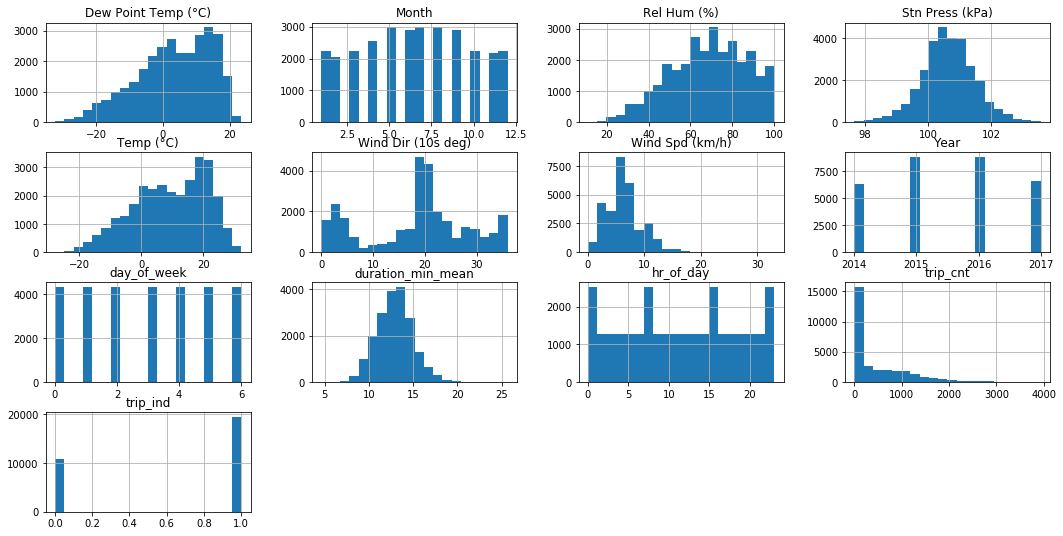

In [13]:
## ========================================================================= ##
## exploratory analysis of trips
## ========================================================================= ##

## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## generic data exploration
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

%matplotlib inline
dat_hr_all.hist(bins = 20, figsize = (18, 9))



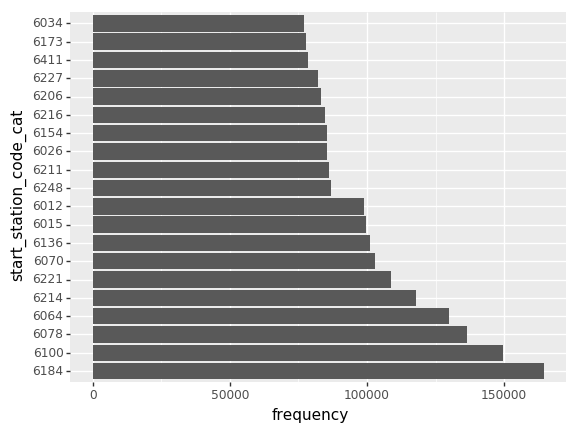

<ggplot: (-9223372029306791308)>

In [14]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## most common starting stations
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## most common starting stations:
start_station_counter = collections.Counter(dat_trip_raw['start_station_code'])
start_station_counter.most_common(10)

## make pandas data frame for visualizing with ggplot/plotnine:
dat_start_station_freq = pd.DataFrame(
    start_station_counter.most_common(20),
    columns = ['start_station_code', 'frequency'])
dat_start_station_freq.rename(index = dat_start_station_freq['start_station_code'], inplace = True)

## frequency series (for sorting):
## (pandas series with index that corresponds to categories):
dat_start_station_freq['frequency']

## create list for sorting:
#station_list = dat_start_station_freq['start_station_code'].value_counts().index.tolist()
station_list = dat_start_station_freq['frequency'].index.tolist()
station_cat = CategoricalDtype(categories=station_list, ordered=True)
dat_start_station_freq['start_station_code_cat'] = \
    dat_start_station_freq['start_station_code'].astype(str).astype(station_cat)

## plot counter data (frequency table, with identity relation):
## (sorting does not work here)
ggplot(dat_start_station_freq, aes(x = 'start_station_code_cat', y = 'frequency')) + \
    geom_bar(stat = 'identity') + \
    coord_flip()

In [15]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## total number of trips
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## total number of trips:
dat_trip_raw.shape[0]  #  14 598 961 (14 Mio)


14598961

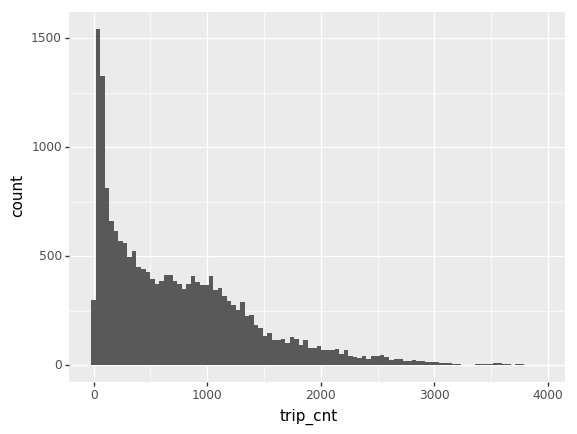

<ggplot: (7544220073)>


trip_cnt
count  30360.000000
mean     480.861693
std      637.774217
min        0.000000
25%        0.000000
50%      162.000000
75%      828.000000
max     3932.000000

In [16]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## number of trips
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## histogram of number of trips per hour:
ggplot(dat_trip_hr, aes(x = 'trip_cnt')) + geom_histogram(bins = 100)
print(ggplot(dat_trip_hr[dat_trip_hr['trip_cnt'] > 0], 
       aes(x = 'trip_cnt')) + geom_histogram(bins = 100))

dat_trip_hr[['trip_cnt']].describe()


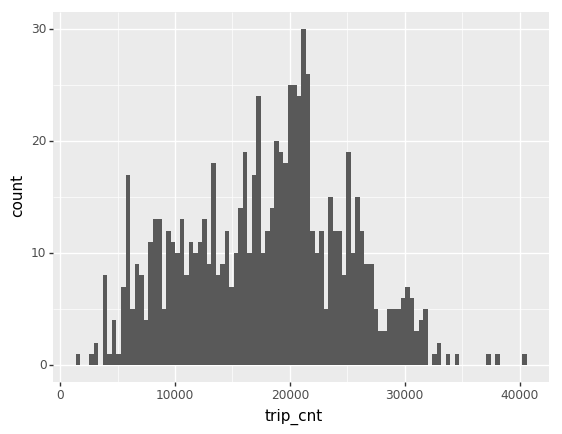

<ggplot: (7551481401)>


trip_cnt
count   1265.000000
mean   11540.680632
std    10247.545477
min        0.000000
25%        0.000000
50%    11844.000000
75%    20412.000000
max    40441.000000

In [17]:
## histogram of number of trips per day:
ggplot(dat_trip_day, aes(x = 'trip_cnt')) + geom_histogram(bins = 100)
print(ggplot(dat_trip_day[dat_trip_day['trip_cnt'] > 0], 
       aes(x = 'trip_cnt')) + geom_histogram(bins = 100))

dat_trip_day[['trip_cnt']].describe()

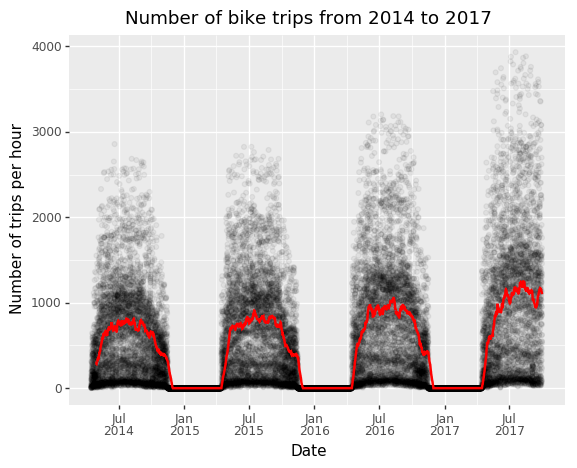

<ggplot: (7546497407)>


In [18]:
## define window for rolling mean and calculate:
window = 14*24
dat_trip_hr["trip_cnt_rollmean"] = dat_trip_hr[["trip_cnt"]]\
    .rolling(window = window, center = False).\
    mean()

%matplotlib inline
## line plot of number of trips per hour:
p = ggplot(dat_trip_hr, aes(y = 'trip_cnt', x = 'start_date')) + \
    geom_point(alpha = .05) + \
    geom_smooth(method = 'mavg', method_args = {'window' : window}, 
                color = 'red', se = False) + \
    labs(
        title = 'Number of bike trips from 2014 to 2017',
        x = 'Date',
        y = 'Number of trips per hour'
    ) + \
    scale_x_date(date_labels = "%b\n%Y")
    #geom_line(aes(y = 'trip_cnt_rollmean'), color = "lightgreen") + \
print(p)

In [19]:
## select subset of data and drop missing values:
dat_tmp = dat_trip_hr[["trip_cnt", "trip_cnt_rollmean"]].dropna()

## select another subset of this for only specified months (with rides):
summer_idx = (dat_trip_hr['start_date'].dt.month >= 5) & (dat_trip_hr['start_date'].dt.month <= 10)
dat_summer = dat_tmp[summer_idx]
dat_summer = dat_summer[["trip_cnt", "trip_cnt_rollmean"]].dropna()
# np.sum(dat_summer['trip_cnt'] == 0)

## correlation and explained variance of rolling mean and actual trip count:
rollmean_r = dat_trip_hr[["trip_cnt", "trip_cnt_rollmean"]].corr()
rollmean_r2 = rollmean_r ** 2
rollmean_r2
rollmean_r = dat_tmp.corr()
rollmean_r2 = rollmean_r ** 2
rollmean_r2
print("r^2 for moving average, all data    = ", r2_score(dat_tmp[["trip_cnt"]], dat_tmp[["trip_cnt_rollmean"]]))
print("r^2 for moving average, summer data = ", r2_score(dat_summer[["trip_cnt"]], dat_summer[["trip_cnt_rollmean"]]))

## mean absolute error: 
print("MAE for moving average, all data    = ", mean_absolute_error(dat_tmp[["trip_cnt"]], dat_tmp[["trip_cnt_rollmean"]]))
print("MAE for moving average, summer data = ", mean_absolute_error(dat_summer[["trip_cnt"]], dat_summer[["trip_cnt_rollmean"]]))


r^2 for moving average, all data    =  0.3875047463731084
r^2 for moving average, summer data =  0.0787075005299196
MAE for moving average, all data    =  316.1594449070219
MAE for moving average, summer data =  510.71442062788475


/Users/ingonader/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 857 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


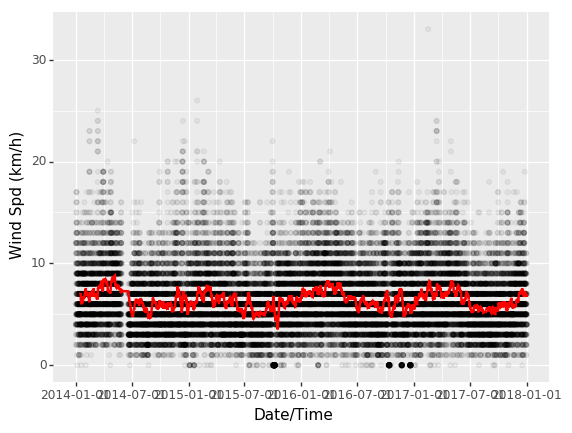

<ggplot: (-9223372029314772876)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 768 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


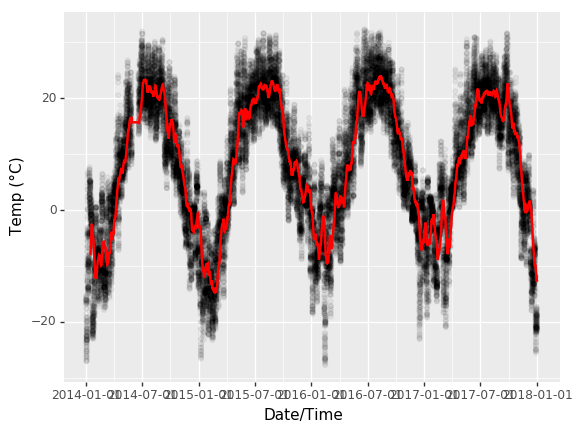

<ggplot: (7546223252)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 836 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


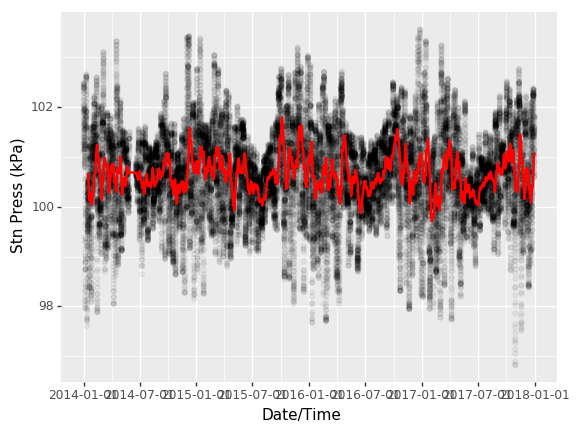

<ggplot: (7547588409)>


In [20]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## weather data
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## line plot of number of some weather metrics

## select which metrics to plot (or not plot):
wch_cols = list(set(dat_weather_raw.columns) - set(['Date/Time', 'Year', 'Month']))

for i in wch_cols[:3]:
    p = ggplot(dat_weather_raw, aes(y = i, x = 'Date/Time')) + \
        geom_point(alpha = .05) + \
        geom_smooth(method = 'mavg', method_args = {'window' : 14*24}, 
                color = 'red', se = False)
    print(p)


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 764 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


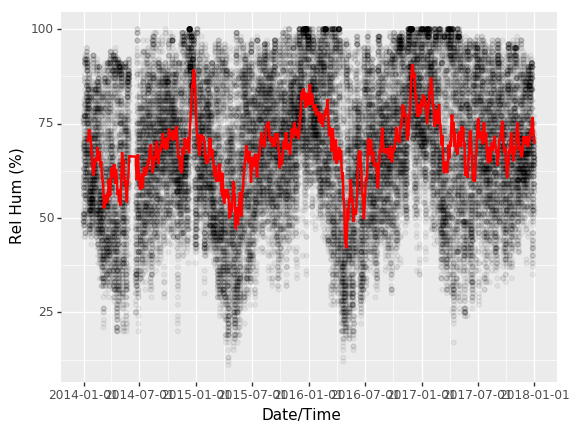

<ggplot: (7546497358)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 25756 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


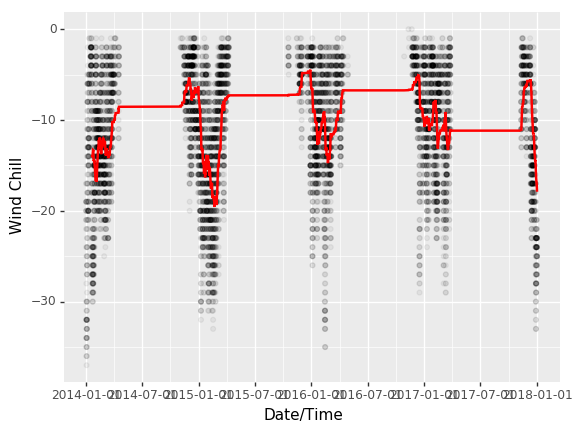

<ggplot: (-9223372029312806428)>


/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1278 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


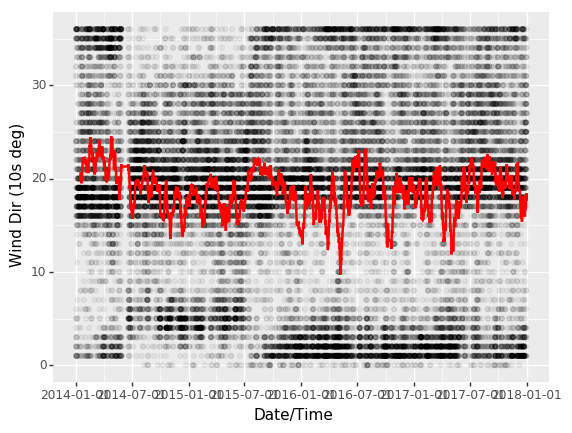

<ggplot: (7551707901)>


In [21]:
for i in wch_cols[3:6]:
    p = ggplot(dat_weather_raw, aes(y = i, x = 'Date/Time')) + \
        geom_point(alpha = .05) + \
        geom_smooth(method = 'mavg', method_args = {'window' : 14*24}, 
                color = 'red', se = False)
    print(p)

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 764 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


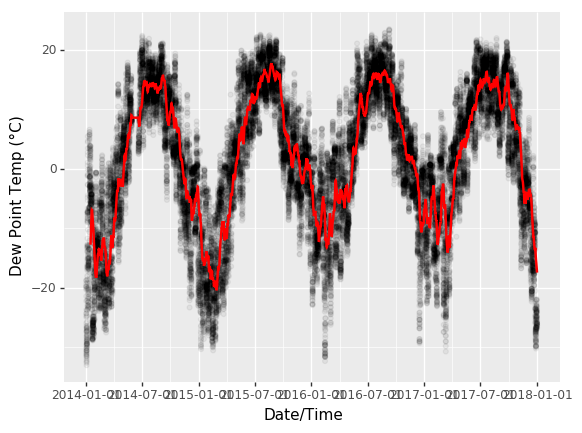

<ggplot: (-9223372029307302796)>


In [22]:
for i in wch_cols[6:]:
    p = ggplot(dat_weather_raw, aes(y = i, x = 'Date/Time')) + \
        geom_point(alpha = .05) + \
        geom_smooth(method = 'mavg', method_args = {'window' : 14*24}, 
                color = 'red', se = False)
    print(p)

In [23]:
dat_weather_raw.describe()
dat_weather_raw.info()
dat_weather_raw.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 743
Data columns (total 10 columns):
Date/Time              35064 non-null datetime64[ns]
Year                   35064 non-null int64
Month                  35064 non-null int64
Temp (°C)              34296 non-null float64
Dew Point Temp (°C)    34300 non-null float64
Rel Hum (%)            34300 non-null float64
Wind Dir (10s deg)     33786 non-null float64
Wind Spd (km/h)        34207 non-null float64
Stn Press (kPa)        34228 non-null float64
Wind Chill             9308 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.9 MB


Date/Time  Year  Month  Temp (°C)  Dew Point Temp (°C)  \
0 2014-01-01 00:00:00  2014      1      -16.5                -19.8   
1 2014-01-01 01:00:00  2014      1      -16.2                -19.7   
2 2014-01-01 02:00:00  2014      1      -16.8                -20.1   
3 2014-01-01 03:00:00  2014      1      -16.1                -19.3   
4 2014-01-01 04:00:00  2014      1      -15.6                -18.8   

   Rel Hum (%)  Wind Dir (10s deg)  Wind Spd (km/h)  Stn Press (kPa)  \
0         76.0                21.0              5.0           101.10   
1         75.0                23.0              6.0           101.14   
2         76.0                24.0             12.0           101.24   
3         76.0                24.0              7.0           101.28   
4         77.0                22.0              4.0           101.32   

   Wind Chill  
0       -20.0  
1       -21.0  
2       -24.0  
3       -21.0  
4       -19.0

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 713 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


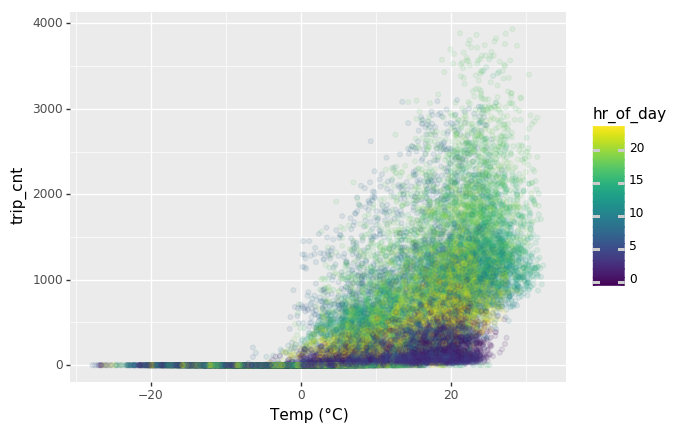

<ggplot: (7550177782)>

In [24]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## multivariate data plots
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

## exploring trip_cnt relationships:
%matplotlib inline
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Temp (°C)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)



/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 802 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


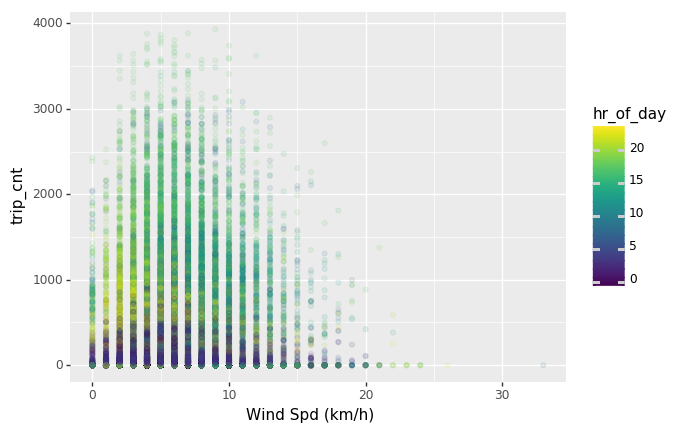

<ggplot: (7546497400)>

In [25]:
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Wind Spd (km/h)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 709 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


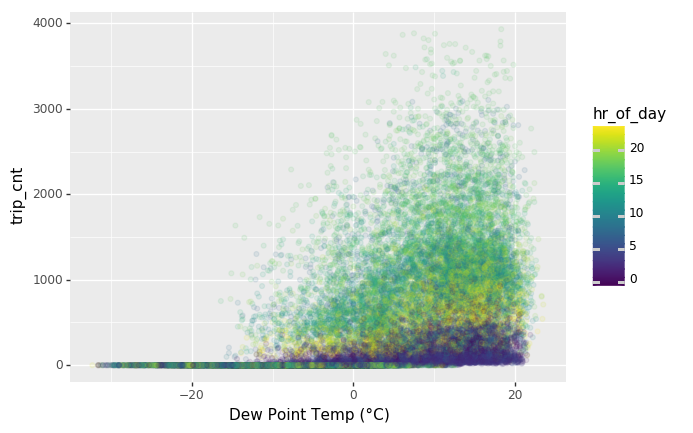

<ggplot: (7544326173)>

In [26]:
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Dew Point Temp (°C)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)



/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 709 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


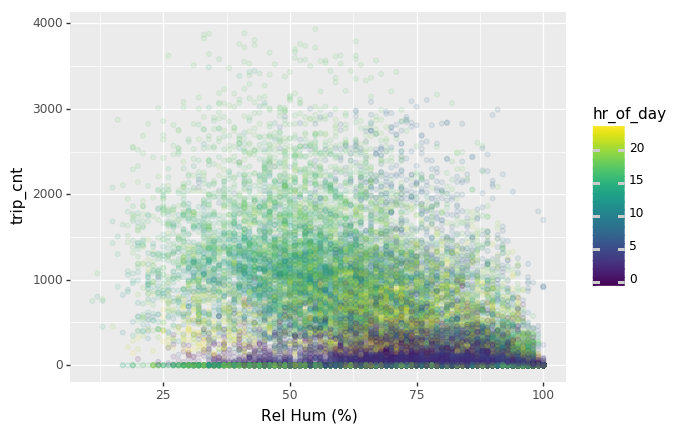

<ggplot: (7545484636)>

In [27]:
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Rel Hum (%)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)



/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1211 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


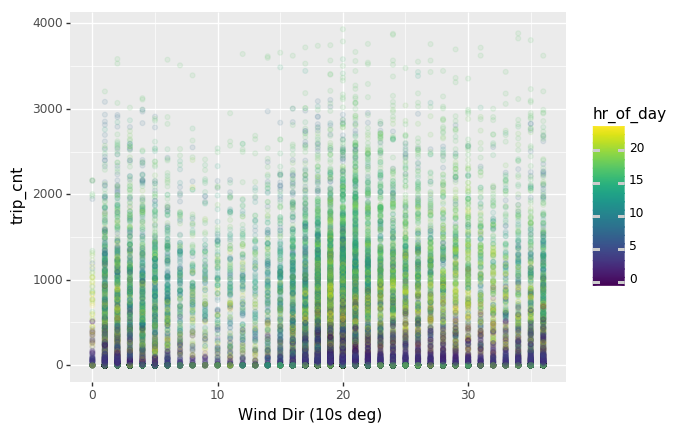

<ggplot: (7545484552)>

In [28]:
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Wind Dir (10s deg)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)



/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 773 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


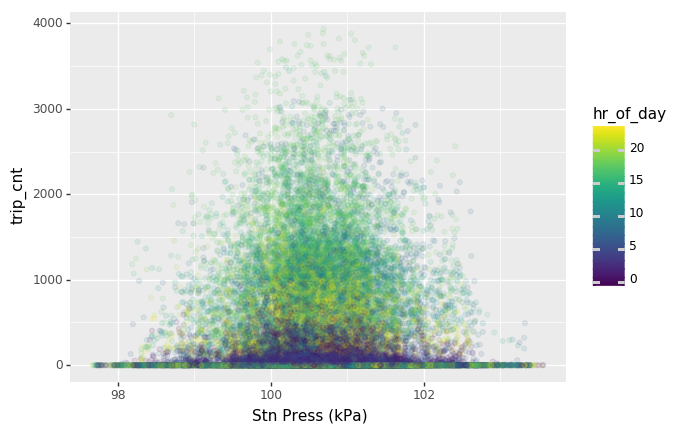

<ggplot: (-9223372029312281568)>

In [29]:
ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'Stn Press (kPa)', color = 'hr_of_day')) + \
    geom_point(alpha = .1)


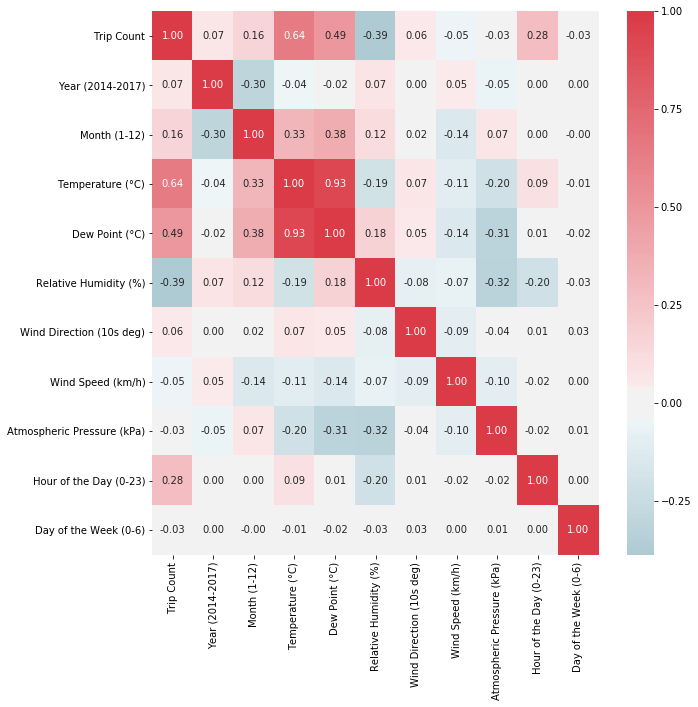

In [30]:
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##
## check correlations
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ##

#dat_hr_all.columns
varnames_cor = ['trip_cnt', 'Year', 'Month', 'Temp (°C)', 
                'Dew Point Temp (°C)', 'Rel Hum (%)',
                'Wind Dir (10s deg)', 'Wind Spd (km/h)', 
                'Stn Press (kPa)', 'hr_of_day', 'day_of_week']

dat_cor = dat_hr_all[varnames_cor]

## correlation:
dat_cor.corr()
cormat = dat_cor.corr()

## correlation heatmap:

## simple:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cormat, cmap = colormap)

varnames_heatmap_long = [varnames_orig_long_dict[i] for i in cormat.columns]

## more complex:
%matplotlib inline
#%matplotlib osx
fig, ax = plt.subplots(figsize = (10, 10))
#Generate Color Map, red & blue
colormap = sns.diverging_palette(220, 10, as_cmap = True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(cormat, cmap = colormap, annot = True, fmt = ".2f", center = 0)
## Apply axes tickmarks of more explicit variable names:
plt.xticks(np.arange(0, len(cormat.columns)) + .5, varnames_heatmap_long)
plt.yticks(np.arange(0, len(cormat.columns)) + .5, varnames_heatmap_long)
plt.show()

## Modeling: Gradient Boosting Regression (scikit-learn)

In [31]:
## ------------------------------------------------------------------------- ##
## define features and formula
## ------------------------------------------------------------------------- ##

## convert categorical variables to strings
## (in order for patsy to automatically dummy-code them without
## having to use the C() function):

# dat_hr_all['Month'] = dat_hr_all['Month'].astype('str')
# dat_hr_all['hr_of_day'] = dat_hr_all['hr_of_day'].astype('str')

## interesting:
## accuracy seems to be higher for non-categorical features!

## define target and features:
target = 'trip_cnt'
features = ['Month',
            'Temp (°C)',
            # 'Dew Point Temp (°C)', ## -- exclude, because highly correlated with Temp
            'Rel Hum (%)',
            'Wind Dir (10s deg)',
            'Wind Spd (km/h)',
            'Stn Press (kPa)',
            'hr_of_day',
            'day_of_week']
list(dat_hr_all)

## add patsy-quoting to features (for weird column names):
target = 'Q(\'' + target + '\')' 
features = ['Q(\'' + i + '\')' for i in features]

## formula as text for patsy: without interactions
formula_txt = target + ' ~ ' + \
    ' + '.join(features) + ' - 1'
formula_txt

# ## try all twofold interactions, in order to 
# ## find important ones via variable importance plots:
# formula_txt = target + ' ~ (' + ' + '.join(features) + ') ** 2 - 1'
# formula_txt

## create design matrices using patsy (could directly be used for modeling):
#patsy.dmatrix?
dat_y, dat_x = patsy.dmatrices(formula_txt, dat_hr_all, 
                               NA_action = 'drop',
                               return_type = 'dataframe')
dat_x.head()

## other possibilities for dummy coding:
## * pd.get_dummies [[?]] which to use?

## ------------------------------------------------------------------------- ##
## train / test split
## ------------------------------------------------------------------------- ##

## Split the data into training/testing sets (using patsy/dmatrices):
dat_train_x, dat_test_x, dat_train_y, dat_test_y = train_test_split(
    dat_x, dat_y, test_size = 0.1, random_state = 142)

## convert y's to Series (to match data types between patsy and non-patsy data prep:)
dat_train_y = dat_train_y[target]
dat_test_y = dat_test_y[target]

#dat_test_x.shape

## ------------------------------------------------------------------------- ##
## estimate model and evaluate fit and model assumptions
## ------------------------------------------------------------------------- ##

## Instantiate random forest estimator:
mod_gb = GradientBoostingRegressor(n_estimators = 100, 
                                   random_state = 42,
                                   loss = 'ls',
                                   learning_rate = 0.1,
                                   max_depth = 20, 
                                   min_samples_split = 70,
                                   min_samples_leaf = 30,
                                   verbose = 0)


In [32]:
## ------------------------------------------------------------------------- ##
## Randomized Search Cross-validation
## ------------------------------------------------------------------------- ##

## [[here]] [[todo]] 
## * different distributions to sample from? (double values, log scale?)
##   (more reserach needed here)

# specify parameters and distributions to sample from:
param_distributions = { 
    "n_estimators" : stats.randint(50, 201),
    "learning_rate" : [0.2, 0.1, 0.05], # stats.uniform(0.05, 0.2 - 0.05),
    "max_depth" : stats.randint(4, 21),
    #"min_samples_split" : stats.randint(40, 101),
    "min_samples_leaf" : stats.randint(30, 61)
}

#stats.randint(1, 4).rvs(20)

n_iter = 40
mod_randsearch = RandomizedSearchCV(
    estimator = mod_gb,
    param_distributions = param_distributions,
    n_iter = n_iter,
    scoring = "r2", ## "roc_auc", # "neg_mean_squared_error", "neg_mean_absolute_error"
    cv = 4,   ## k-fold cross-validation for binary classification
    verbose = 2,
    random_state = 7,
    n_jobs = -1)
mod_randsearch.fit(dat_train_x, dat_train_y)


Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153 
[CV] learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153 
[CV] learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153 
[CV] learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153 
[CV]  learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153, total=  27.3s
[CV]  learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153, total=  27.1s
[CV] learning_rate=0.2, max_depth=18, min_samples_leaf=53, n_estimators=122 
[CV] learning_rate=0.2, max_depth=18, min_samples_leaf=53, n_estimators=122 
[CV]  learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153, total=  27.3s
[CV] learning_rate=0.2, max_depth=18, min_samples_leaf=53, n_estimators=122 
[CV]  learning_rate=0.2, max_depth=7, min_samples_leaf=49, n_estimators=153, total=  27.7s
[CV] learning_rate=0.2, max_depth=18, m

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min


[CV]  learning_rate=0.2, max_depth=18, min_samples_leaf=39, n_estimators=137, total=  29.3s
[CV] learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194 
[CV]  learning_rate=0.2, max_depth=18, min_samples_leaf=39, n_estimators=137, total=  29.0s
[CV] learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194 
[CV]  learning_rate=0.2, max_depth=18, min_samples_leaf=39, n_estimators=137, total=  31.3s
[CV] learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194 
[CV]  learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194, total=  44.7s
[CV] learning_rate=0.05, max_depth=16, min_samples_leaf=58, n_estimators=121 
[CV]  learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194, total=  46.4s
[CV]  learning_rate=0.2, max_depth=20, min_samples_leaf=31, n_estimators=194, total=  46.0s
[CV] learning_rate=0.05, max_depth=16, min_samples_leaf=58, n_estimators=121 
[CV] learning_rate=0.05, max_depth=16, min_samples_leaf=58, n

[CV]  learning_rate=0.1, max_depth=19, min_samples_leaf=57, n_estimators=85, total=  24.7s
[CV] learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104 
[CV]  learning_rate=0.1, max_depth=19, min_samples_leaf=57, n_estimators=85, total=  25.7s
[CV] learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104 
[CV]  learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104, total=  15.7s
[CV] learning_rate=0.1, max_depth=11, min_samples_leaf=33, n_estimators=190 
[CV]  learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104, total=  16.2s
[CV] learning_rate=0.1, max_depth=11, min_samples_leaf=33, n_estimators=190 
[CV]  learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104, total=  16.3s
[CV] learning_rate=0.1, max_depth=11, min_samples_leaf=33, n_estimators=190 
[CV]  learning_rate=0.2, max_depth=8, min_samples_leaf=41, n_estimators=104, total=  16.6s
[CV] learning_rate=0.1, max_depth=11, min_samples_leaf=33, n_estimators

[CV]  learning_rate=0.1, max_depth=8, min_samples_leaf=57, n_estimators=126, total=  22.4s
[CV] learning_rate=0.1, max_depth=15, min_samples_leaf=36, n_estimators=170 
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=36, n_estimators=170, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_estimators=106 
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=36, n_estimators=170, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_estimators=106 
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=36, n_estimators=170, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_estimators=106 
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=36, n_estimators=170, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_estimators=106 
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_estimators=106, total=  26.7s
[CV]  learning_rate=0.1, max_depth=15, min_samples_leaf=58, n_es

[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 19.6min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=20, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=30,
             min_samples_split=70, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=40, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1c2347fc88>, 'learning_rate': [0.2, 0.1, 0.05], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1c2635ed30>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1c23482128>},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score=

In [33]:
## best parameters and score in CV:
print(mod_randsearch.best_params_)
print(mod_randsearch.best_score_)

## get best model (estimator): 
mod_gb = mod_randsearch.best_estimator_


{'learning_rate': 0.2, 'max_depth': 20, 'min_samples_leaf': 31, 'n_estimators': 194}
0.9368203447909008


In [34]:
## ------------------------------------------------------------------------- ##
## use and inspect model
## ------------------------------------------------------------------------- ##

## Make predictions using the testing set
dat_test_pred = mod_gb.predict(dat_test_x)
dat_train_pred = mod_gb.predict(dat_train_x)

## Inspect model:
print("MSE in training set = ", mean_squared_error(dat_train_y, dat_train_pred))
print("MSE in test set     = ", mean_squared_error(dat_test_y, dat_test_pred))
print("MAE in training set = ", mean_absolute_error(dat_train_y, dat_train_pred))
print("MAE in test set     = ", mean_absolute_error(dat_test_y, dat_test_pred))
print("R^2 (r squared) in training set = ", r2_score(dat_train_y, dat_train_pred))
print("R^2 (r squared) in test set     = ", r2_score(dat_test_y, dat_test_pred))



MSE in training set =  1131.8311756882306
MSE in test set     =  24380.2368307682
MAE in training set =  20.53872610723376
MAE in test set     =  85.43290047952202
R^2 (r squared) in training set =  0.9972350955869683
R^2 (r squared) in test set     =  0.9406105250603446


In [35]:
## ------------------------------------------------------------------------- ##
## save model to disk
## ------------------------------------------------------------------------- ##

## [[?]] who to persist models?
## * don't use pickle or joblib (unsafe and not persistent)
##   see https://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html or
##   http://scikit-learn.org/stable/modules/model_persistence.html
##   (3.4.2. Security & maintainability limitations)

from sklearn.externals import joblib

# filename_model = 'model_gradient_boosting_interactions.pkl'
filename_model = 'model_gradient_boosting.pkl'

## don't actually save it here, only save it in original analysis (.py files)
#joblib.dump(mod_gb, os.path.join(path_out, filename_model))


## Model inspection

In [36]:
## ========================================================================= ##
## load model from disk
## ========================================================================= ##

filename_model = 'model_gradient_boosting.pkl'; filename_out_prefix = 'mod_gb_'; n_jobs = -2; comment_str = ""

## load model:
mod_this = joblib.load(os.path.join(path_out, filename_model))

## define number of grid points for pdp interaction plots:
num_grid_points_int = [20, 20]
num_grid_points_main = 40

dat_perf_metrics = {
    'timestamp' : pd.Timestamp.today(),
    'timestamp_str' : str(pd.Timestamp.today()),
    'filename_model' : filename_model,
    'filename_out_prefix' : filename_out_prefix
}
pd.DataFrame.from_dict(dat_perf_metrics, orient = "index")

0
timestamp             2018-11-12 12:14:16.419543
timestamp_str         2018-11-12 12:14:16.419590
filename_model       model_gradient_boosting.pkl
filename_out_prefix                      mod_gb_

In [37]:
## ========================================================================= ##
## make predictions and get model performance
## ========================================================================= ##

## [[here]]
## * select only summer data (month >= 5 and <= 9)
dat_test_summer_x = dat_test_x[(dat_test_x["Q('Month')"] >= 5) & (dat_test_x["Q('Month')"] <= 59)]
dat_test_summer_y = dat_test_y[(dat_test_x["Q('Month')"] >= 5) & (dat_test_x["Q('Month')"] <= 59)]

## Make predictions using the testing set
dat_train_pred = mod_this.predict(dat_train_x)
dat_test_pred = mod_this.predict(dat_test_x)
dat_test_summer_pred = mod_this.predict(dat_test_summer_x)

## Inspect model:
this_perf_metrics = {
    'mse_train' : mean_squared_error(dat_train_y, dat_train_pred),  # MSE in training set
    'mse_test'  : mean_squared_error(dat_test_y, dat_test_pred),    # MSE in test set
    'mae_train' : mean_absolute_error(dat_train_y, dat_train_pred), # MAE in training set
    'mae_test'  : mean_absolute_error(dat_test_y, dat_test_pred),   # MAE in test set
    'mae_test_summer' : mean_absolute_error(dat_test_summer_y, dat_test_summer_pred),   
    'r2_train'  : r2_score(dat_train_y, dat_train_pred),            # R^2 (r squared) in test set
    'r2_test'   : r2_score(dat_test_y, dat_test_pred),              # R^2 (r squared) in test set
    'r2_test_summer' : r2_score(dat_test_summer_y, dat_test_summer_pred)
}
#pd.DataFrame(this_perf_metrics, index = [0])
dat_perf_metrics.update(this_perf_metrics)
pd.DataFrame.from_dict(dat_perf_metrics, orient = "index")

## r2 for non-zero bike trips counts:
this_perf_metrics = {
    'r2_train_nonzero' : r2_score(dat_train_y[dat_train_y > 0], dat_train_pred[dat_train_y > 0]),
    'r2_test_nonzero' : r2_score(dat_test_y[dat_test_y > 0], dat_test_pred[dat_test_y > 0])
}
#pd.DataFrame(this_perf_metrics, index = [0])
dat_perf_metrics.update(this_perf_metrics)
pd.DataFrame.from_dict(dat_perf_metrics, orient = "index")


0
timestamp             2018-11-12 12:14:16.419543
timestamp_str         2018-11-12 12:14:16.419590
filename_model       model_gradient_boosting.pkl
filename_out_prefix                      mod_gb_
mse_train                                1131.83
mse_test                                 24380.2
mae_train                                20.5387
mae_test                                 85.4329
mae_test_summer                          105.423
r2_train                                0.997235
r2_test                                 0.940611
r2_test_summer                           0.93258
r2_train_nonzero                        0.996291
r2_test_nonzero                         0.919841

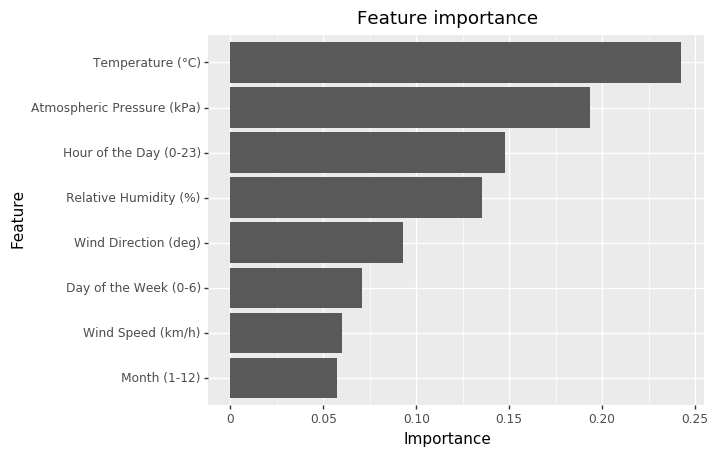

<ggplot: (7539007166)>


In [38]:

## ========================================================================= ##
## variable importance
## ========================================================================= ##

## variable importance:
var_imp = pd.DataFrame(
    {'varname_q'   : dat_train_x.columns,   ## quoted
     'varname_orig'   : [i[3:-2] for i in dat_train_x.columns], 
    'importance' : list(mod_this.feature_importances_)})
dat_varnames_long = pd.DataFrame.from_dict(varnames_long_dict, orient = 'index', columns = ['varname'])
var_imp = pd.merge(var_imp, dat_varnames_long, 
                   left_on = 'varname_q', right_index = True, 
                   how = 'left')
## for missing "varnames" (not defined in dat_varnames_long, e.g., interactions),
## use varname_q instead:
var_imp['varname'] = np.where(pd.isnull(var_imp['varname']), 
                                        var_imp['varname_q'], var_imp['varname'])
var_imp.sort_values('importance', ascending = False, inplace = True)
var_imp.head(n = 15)
#print(var_imp[['varname', 'importance']].head(n = 15))

## sort variables by importance for plotting:
varname_list = list(var_imp.sort_values('importance')['varname'])
varname_cat = CategoricalDtype(categories = varname_list, ordered=True)
var_imp['varname_cat'] = \
    var_imp['varname'].astype(str).astype(varname_cat)

## plot variable importance (15 most important):
p = ggplot(var_imp[:15], aes(y = 'importance', x = 'varname_cat')) + \
    geom_bar(stat = 'identity') + \
    labs(
        title = "Feature importance",
        x = "Feature",
        y = "Importance") + \
    coord_flip()
print(p)


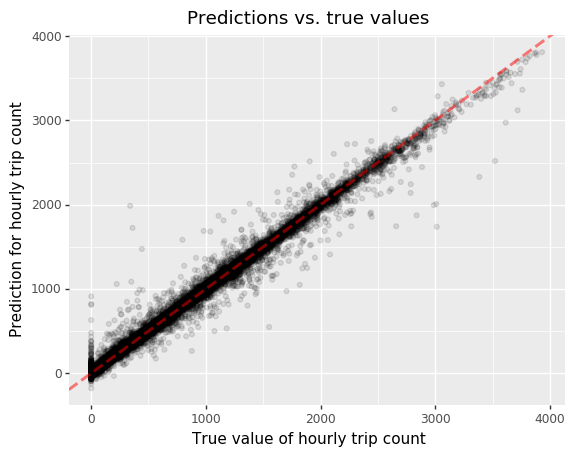

<ggplot: (-9223372029309290699)>


In [39]:
## ========================================================================= ##
## plot data with predictions
## ========================================================================= ##

## make predictions for complete dataset:
dat_y['pred'] = mod_this.predict(dat_x)
dat_y.head()

## add to original dataset:
dat_hr_all = pd.merge(dat_hr_all, 
                      dat_y[['pred']], 
                      how = 'left',
                      left_index = True,
                      right_index = True)

## plot predictions vs. real value of target:
p = ggplot(dat_y, aes(x = "Q('trip_cnt')", y = 'pred')) + \
    geom_point(alpha = .1) + \
    geom_abline(intercept = 0, slope = 1, 
                color = "red", 
                alpha = .5,
                linetype = "dashed",
                size = 1.2) + \
    labs(
        title = "Predictions vs. true values",
        x = "True value of hourly trip count",
        y = "Prediction for hourly trip count")
print(p)

/Users/ingonader/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 1284 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


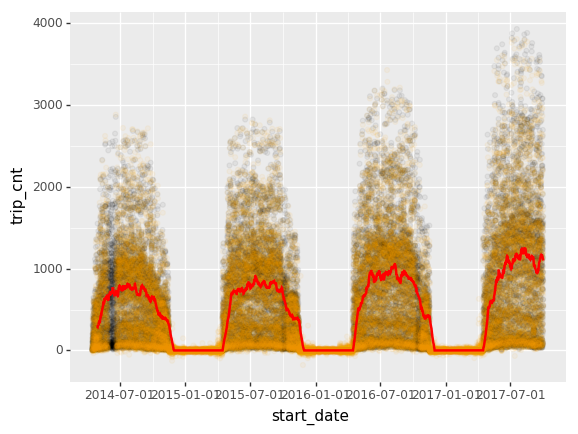

<ggplot: (-9223372029309291141)>


In [40]:
p = ggplot(dat_hr_all, aes(y = 'trip_cnt', x = 'start_date')) + \
    geom_point(alpha = .05, color = 'black') + \
    geom_point(aes(y = 'pred'), alpha = .05, color = 'orange') + \
    geom_smooth(method = 'mavg', method_args = {'window' : 14*24}, 
                color = 'red', se = False)
print(p)

In [41]:
## add comment to model or model run:
this_perf_metrics = {
    'comment' : comment_str
}
dat_perf_metrics.update(this_perf_metrics)
#pd.DataFrame(dat_perf_metrics, index = [0])
pd.DataFrame.from_dict(dat_perf_metrics, orient = "index")


0
timestamp             2018-11-12 12:14:16.419543
timestamp_str         2018-11-12 12:14:16.419590
filename_model       model_gradient_boosting.pkl
filename_out_prefix                      mod_gb_
mse_train                                1131.83
mse_test                                 24380.2
mae_train                                20.5387
mae_test                                 85.4329
mae_test_summer                          105.423
r2_train                                0.997235
r2_test                                 0.940611
r2_test_summer                           0.93258
r2_train_nonzero                        0.996291
r2_test_nonzero                         0.919841
comment

In [42]:
filename_model_runs = "model_runs.csv"
## check if file exists:
if os.path.isfile(os.path.join(path_out, filename_model_runs)):
    dat_model_runs = pd.read_csv(os.path.join(path_out, filename_model_runs))
else:
    dat_model_runs = pd.DataFrame()

## append current runs data:
dat_model_runs = pd.concat([dat_model_runs,
                            pd.DataFrame(dat_perf_metrics, index = [0])],
                          sort = True)
## sort columns by order of dict (others at the end):
colnames_dict = list(dat_perf_metrics.keys())
colnames_notindict = list(set(dat_model_runs.columns) - set(colnames_dict))
colnames_ordered = [colnames_dict, colnames_notindict]
colnames_ordered = list(chain(*colnames_ordered)) ## flatten

## reorder columns:
dat_model_runs = dat_model_runs[colnames_dict]
dat_model_runs


timestamp               timestamp_str  \
0  2018-10-18 20:45:26.095202  2018-10-18 20:45:26.096772   
1  2018-10-18 21:46:25.537658  2018-10-18 21:46:25.537687   
2  2018-10-19 07:03:25.426032  2018-10-19 07:03:25.426063   
3  2018-10-19 07:37:02.206377  2018-10-19 07:37:02.206419   
4  2018-10-19 09:05:34.960522  2018-10-19 09:05:34.960540   
5  2018-10-19 09:06:55.446126  2018-10-19 09:06:55.446144   
6  2018-10-23 16:45:38.998156  2018-10-23 16:45:38.998179   
7  2018-10-30 13:14:30.687822  2018-10-30 13:14:30.690339   
8  2018-11-05 21:08:28.847482  2018-11-05 21:08:28.847501   
9  2018-11-05 21:10:53.572418  2018-11-05 21:10:53.572443   
0  2018-11-12 12:14:16.419543  2018-11-12 12:14:16.419590   

                                      filename_model filename_out_prefix  \
0                model_gradient_boosting_imputed.pkl          mod_gbimp_   
1                        model_gradient_boosting.pkl             mod_gb_   
2  model_gradient_boosting_weather_only_with_dewp...        mod_gbwowdp_   
3          model_gradient_boosting_with_dewpoint.pkl          mod_gbwdp_   
4                            model_random_forest.pkl             mod_rf_   
5                                      model_xgb.pkl            mod_xgb_   
6                        model_gradient_boosting.pkl             mod_gb_   
7           model_gradient_boosting_interactions.pkl            mod_gbx_   
8                            model_random_forest.pkl             mod_rf_   
9                                      model_xgb.pkl            mod_xgb_   
0                        model_gradient_boosting.pkl             mod_gb_   

      mse_train       mse_test   mae_train    mae_test  mae_test_summer  \
0   5993.833460   25317.792831   42.703951   84.863533              NaN   
1   1131.831176   24380.236831   20.538726   85.432900              NaN   
2  93838.759490  157681.576476  182.993069  239.995856              NaN   
3   1369.695426   24520.591787   22.534270   83.720711              NaN   
4  35581.942609   43499.692079   99.815111  111.241830              NaN   
5  45383.332139   57419.001709  142.102481  158.004211              NaN   
6   1131.831176   24380.236831   20.538726   85.432900       105.422869   
7   4462.890205   27275.039725   35.233734   85.334731       107.406908   
8  35581.942609   43499.692079   99.815111  111.241830       139.684503   
9  42273.239706   55344.183296  137.997820  155.253901       173.069597   
0   1131.831176   24380.236831   20.538726   85.432900       105.422869   

   r2_train   r2_test  r2_test_summer  r2_train_nonzero  r2_test_nonzero  \
0  0.985306  0.936110             NaN               NaN              NaN   
1  0.997235  0.940611             NaN          0.996291         0.919841   
2  0.770765  0.615893             NaN          0.672344         0.451384   
3  0.996654  0.940269             NaN          0.995604         0.918765   
4  0.913078  0.894036             NaN          0.889665         0.859584   
5  0.889135  0.860129             NaN          0.866169         0.826557   
6  0.997235  0.940611        0.932580          0.996291         0.919841   
7  0.989098  0.933559        0.923143          0.985383         0.909997   
8  0.913078  0.894036        0.880315          0.889665         0.859584   
9  0.896417  0.865749        0.856083          0.875315         0.836068   
0  0.997235  0.940611        0.932580          0.996291         0.919841   

                                             comment  
0  gradient boosting with IterativeImputer() impu...  
1                without using dewpoint as a feature  
2  Including only weather data, but now with dewp...  
3  Including time and weather data, but now with ...  
4  rerun for performance documentation purposes only  
5  rerun for performance documentation purposes only  
6                                                NaN  
7                                                NaN  
8  rerun for performance documentation purposes only  
9  rerun f

In [43]:
## ========================================================================= ##
## partial dependence plots: main effects
## ========================================================================= ##

from pdpbox import pdp, get_dataset, info_plots

# Package scikit-learn (PDP via function plot_partial_dependence() ) 
#   http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
# Package PDPbox (ICE, c-ICE for single and multiple predictors) 
#   https://github.com/SauceCat/PDPbox 

#pd.merge(dat_train_x, pd.DataFrame(dat_train_y), left_index = True, right_index = True)
#dat_train_x.join(dat_train_y)  ## identical


#dat_train_x.columns

%matplotlib inline


plot_params_default = {
            # plot title and subtitle
            'title': '',
            'subtitle': '',
            'title_fontsize': 20,
            'subtitle_fontsize': 12,
            'font_family': 'Arial',
            # matplotlib color map for ICE lines
            'line_cmap': 'Blues',
            'xticks_rotation': 0,
            # pdp line color, highlight color and line width
            'pdp_color': '#1A4E5D',
            'pdp_hl_color': '#FEDC00',
            'pdp_linewidth': 1.5,
            # horizon zero line color and with
            'zero_color': '#E75438',
            'zero_linewidth': 1,
            # pdp std fill color and alpha
            'fill_color': '#66C2D7',
            'fill_alpha': 0.2,
            # marker size for pdp line
            'markersize': 3.5,
        }
plot_ylim_max = 2000  ## the same for all plots, for comparability.

# plot_params_default.update({
#         'title': 'Partial Dependence for: %s' % \
#         varnames_long_dict[wch_feature]
#     })


def construct_pdp(model, feature,
                  dataset_x = dat_train_x, dataset_y = dat_train_y, 
                  num_grid_points = num_grid_points_main, n_jobs = n_jobs,
                 model_features = dat_train_x.columns):
    ## calculation for pdp (and then ice plot) for numeric feature:
    pdp_current = pdp.pdp_isolate(
        model = mod_this, dataset = dataset_x.join(dataset_y), 
        num_grid_points = num_grid_points, n_jobs = n_jobs, ## needs to be 1 for XGBoost model!
        model_features = dataset_x.columns, 
        feature = feature)
    
    ## construct centered pdp plot for numeric features:
    fig_center, axes_center = pdp.pdp_plot(
        pdp_current, varnames_long_dict[feature],
        center = True, 
        plot_params = plot_params_default
    )
    axes_center["pdp_ax"].set_ylabel("Number of bike rides per hour")
    axes_center["pdp_ax"].set_title('Partial Dependence Plot for: %s' % \
        varnames_long_dict[feature], y = 1)
    
    ## construct non-centered pdp plot for numeric features:
    fig, axes = pdp.pdp_plot(
        pdp_current, varnames_long_dict[feature],
        center = False, 
        plot_params = plot_params_default
    )
    axes["pdp_ax"].set_ylabel("Number of bike rides per hour")
    #axes["pdp_ax"].set_ylim(0, plot_ylim_max)
    #axes["pdp_ax"].set_ylim(0, np.max(vars(pdp_current)['count_data']['count']))
    axes["pdp_ax"].set_title('Partial Dependence Plot for: %s' % \
        varnames_long_dict[feature], y = 1)
    #axes["pdp_ax"].margins(0)
    return pdp_current, fig_center, fig

def construct_ice_plot(pdp_current, feature):
    ## centered ice-plot for numeric feature:
    fig_center, axes_center = pdp.pdp_plot(
        pdp_current, varnames_long_dict[wch_feature], #wch_feature, 
        center = True,
        plot_lines = True, frac_to_plot = 100,  ## percentage! 
        x_quantile = False, plot_pts_dist = True, show_percentile = True,
        plot_params = plot_params_default)
    axes_center["pdp_ax"]["_pdp_ax"].set_ylabel("Number of bike rides per hour")
    axes_center["pdp_ax"]["_pdp_ax"].set_title('Partial Dependence and ICE Plot for: %s' % \
        varnames_long_dict[feature], y = 1.1)
    ## standard ice-plot for numeric feature:
    fig, axes = pdp.pdp_plot(
        pdp_current, varnames_long_dict[wch_feature], #wch_feature, 
        center = False,
        plot_lines = True, frac_to_plot = 100,  ## percentage! 
        x_quantile = False, plot_pts_dist = True, show_percentile = True,
        plot_params = plot_params_default)
    axes["pdp_ax"]["_pdp_ax"].set_ylabel("Number of bike rides per hour")
    #axes["pdp_ax"]["_pdp_ax"].set_ylim(0, np.max(vars(pdp_current)['count_data']['count']))
    axes["pdp_ax"]["_pdp_ax"].set_title('Partial Dependence and ICE Plot for: %s' % \
        varnames_long_dict[feature], y = 1.1)
    return fig_center, fig

def save_pdp_or_ice_plot(fig, feature, filename_stump):
    filename_this = filename_out_prefix + filename_stump + \
        pv.sanitize_python_var_name(feature) + ".jpg"
    print("Saving ", filename_this)
    fig.savefig(fname = os.path.join(path_out, filename_this), 
            dpi = 150, pad_inches = 0.025, bbox_inches = "tight")
    return

## define features to plot:
#features
pdp_plot_features = ["Q('Temp (°C)')", "Q('Stn Press (kPa)')", 
                    "Q('hr_of_day')", "Q('Rel Hum (%)')",
                    "Q('day_of_week')"]


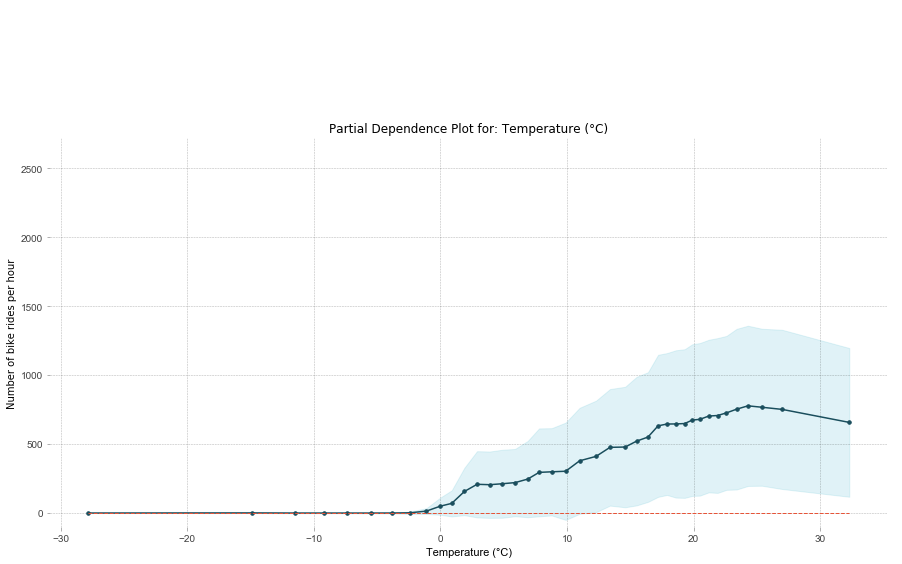

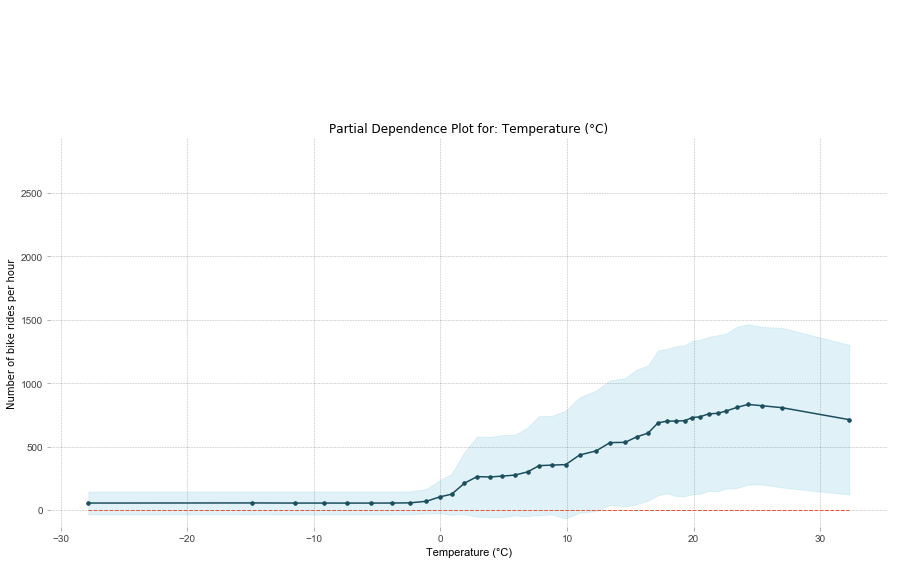

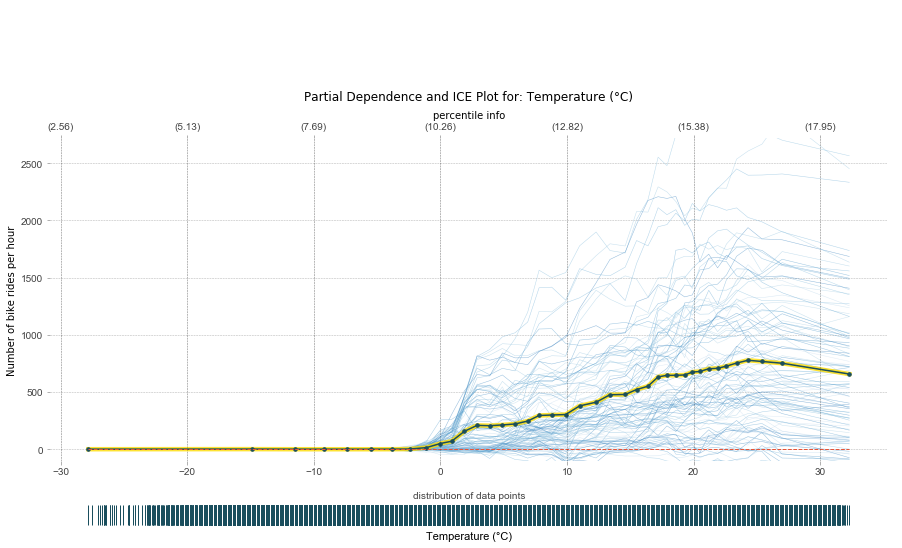

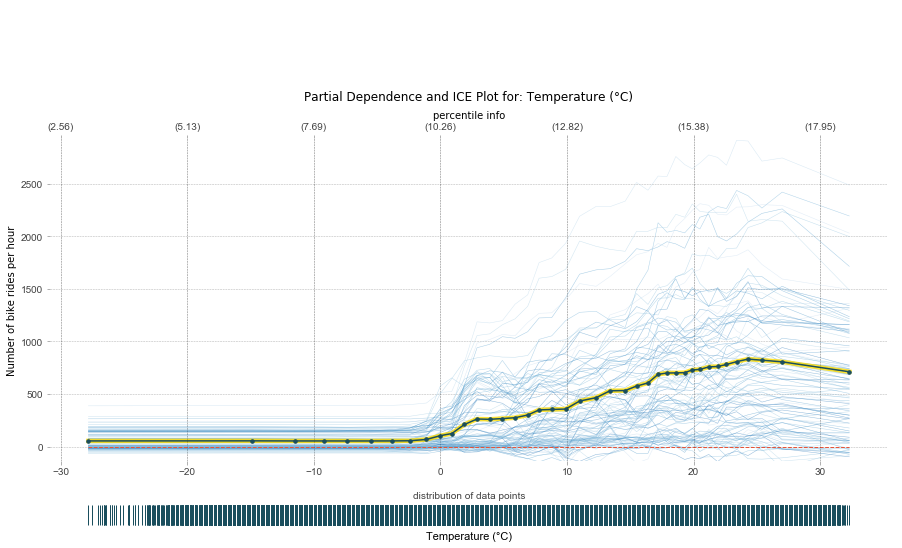

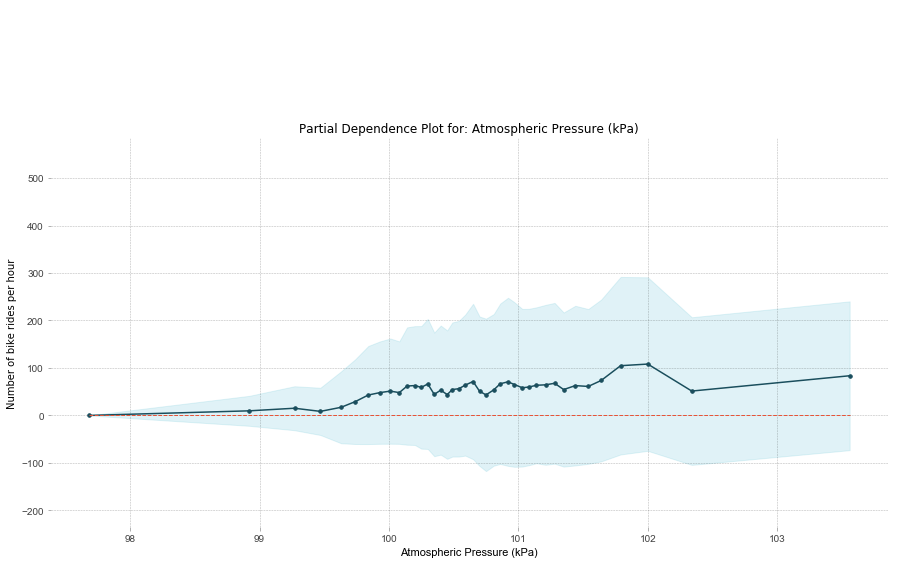

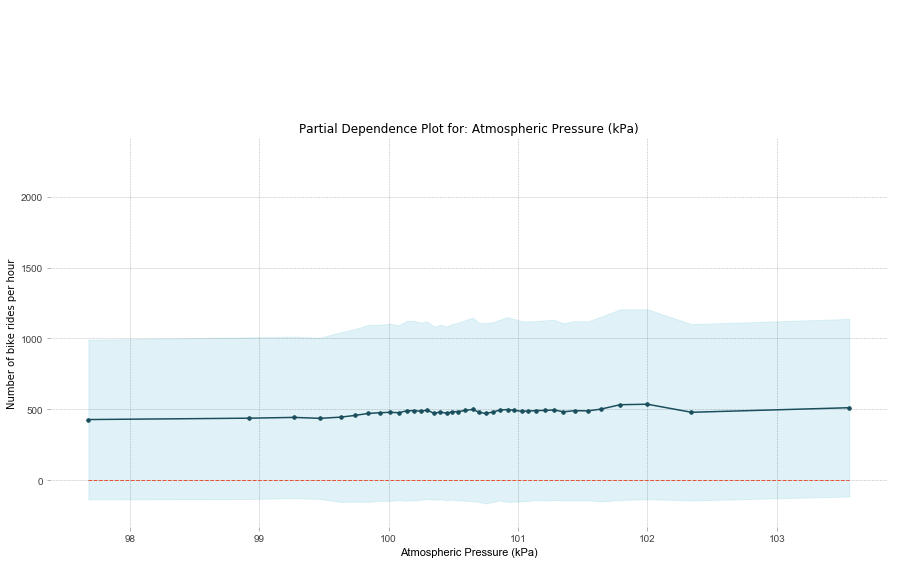

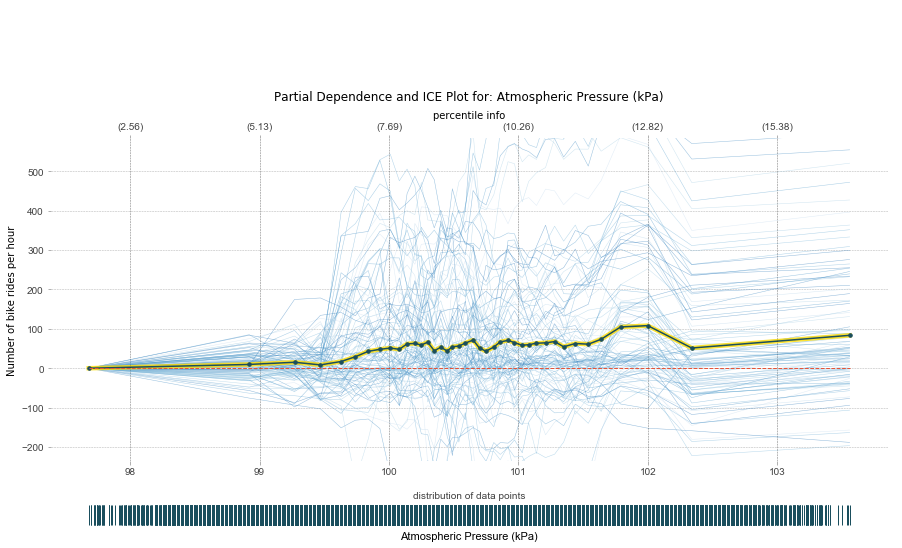

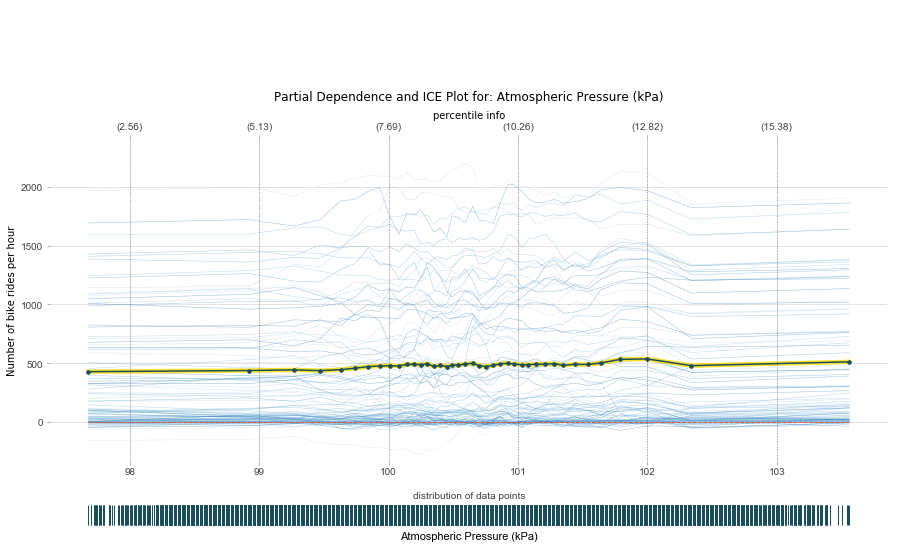

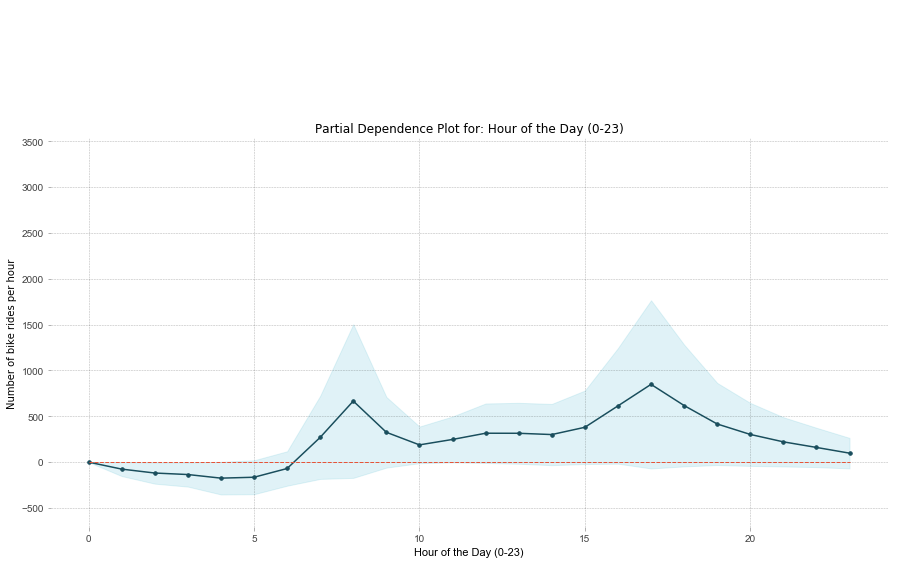

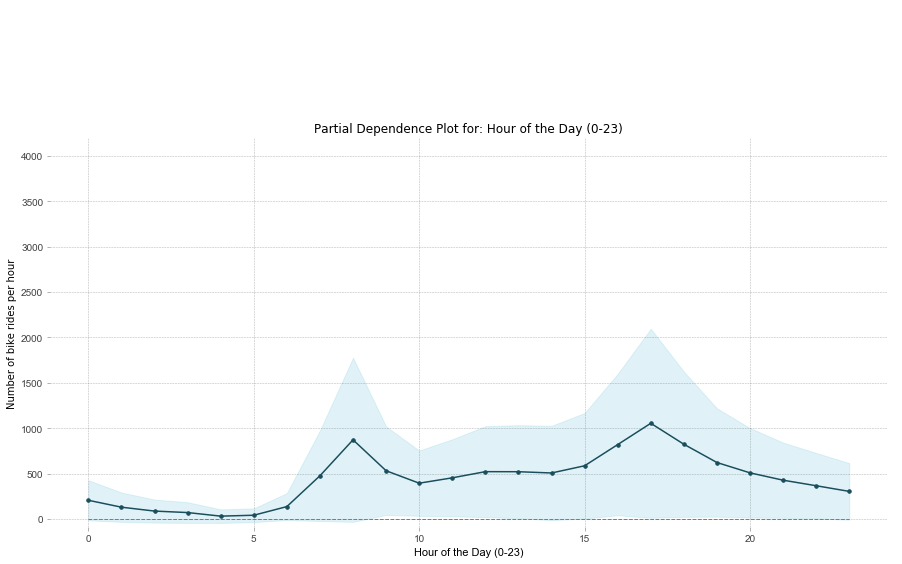

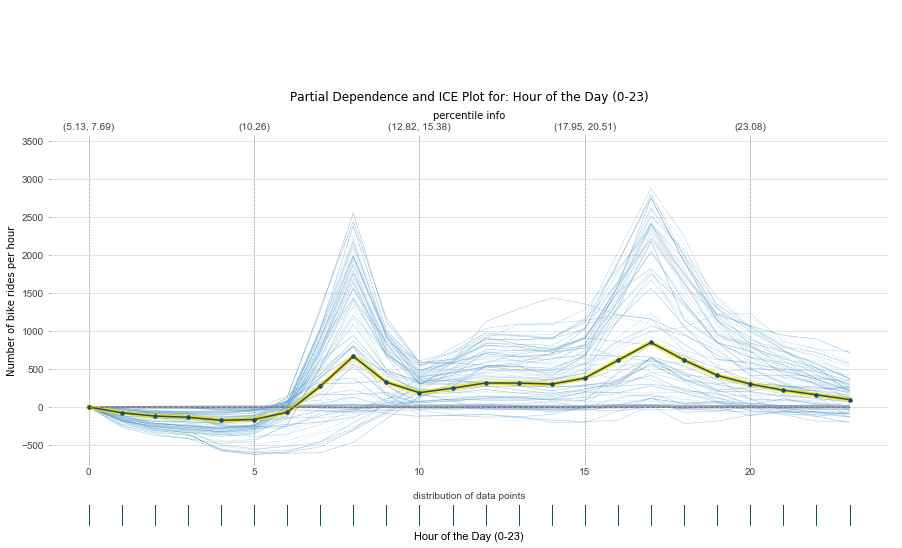

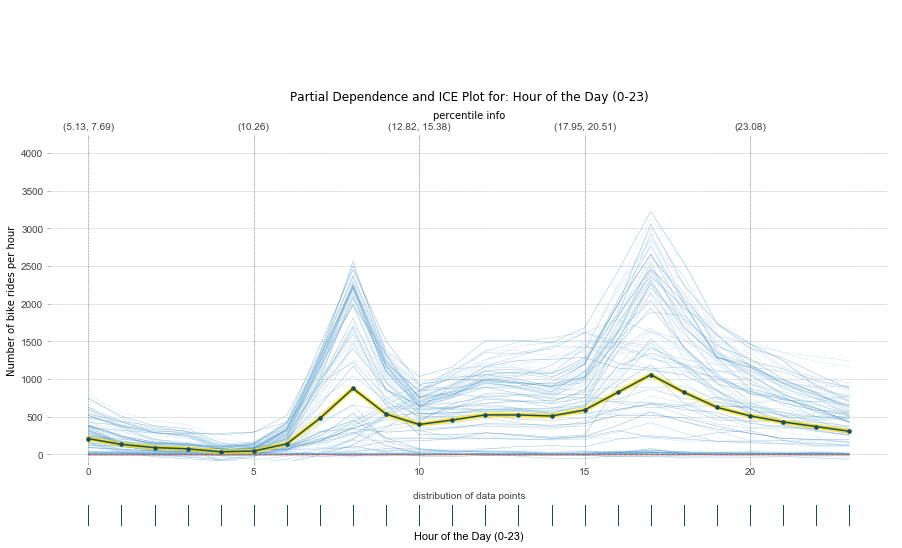

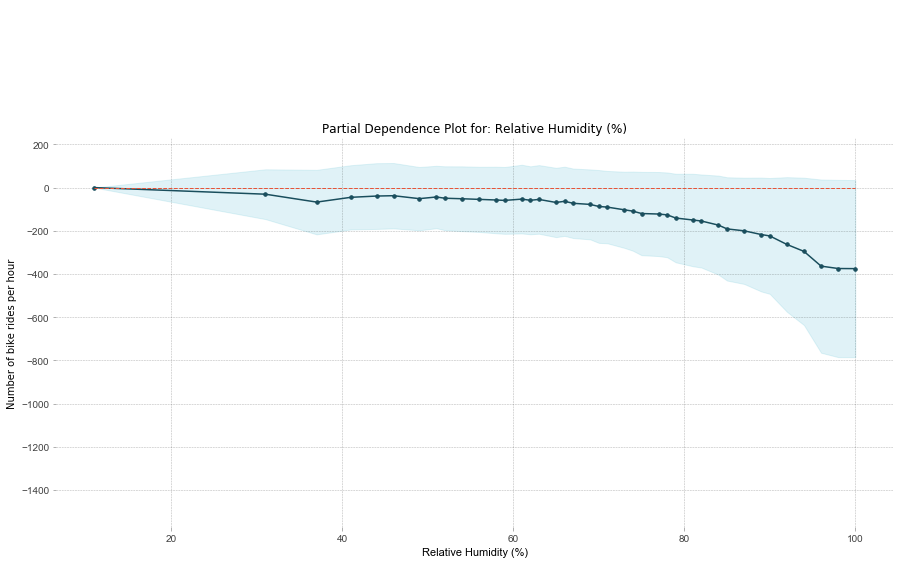

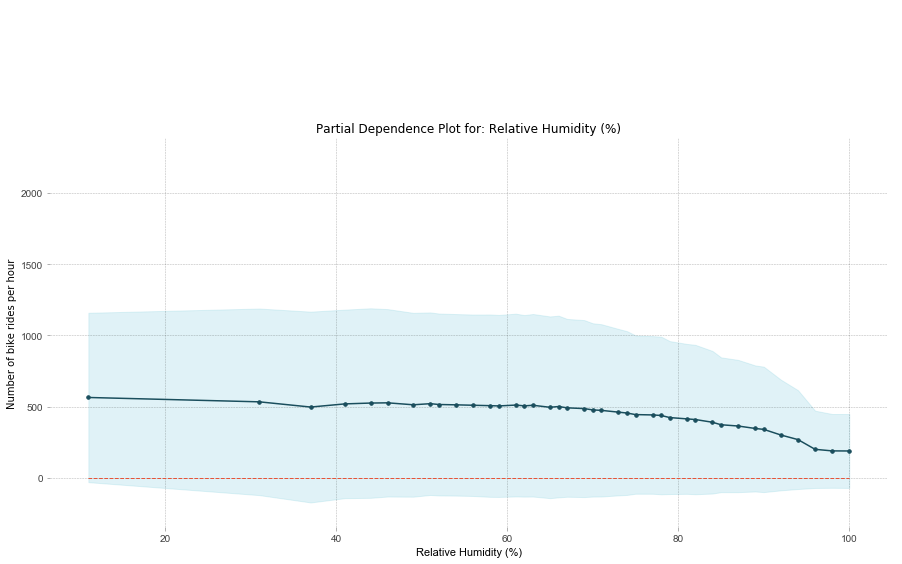

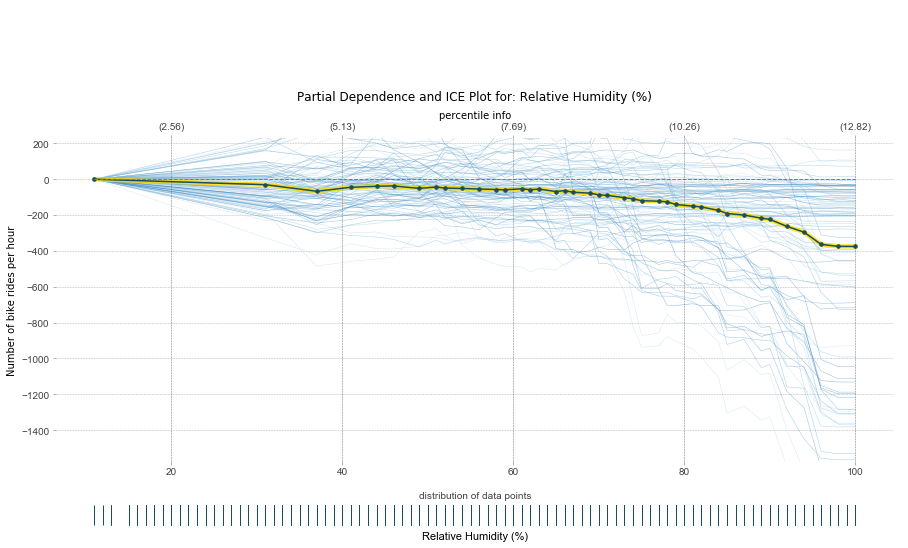

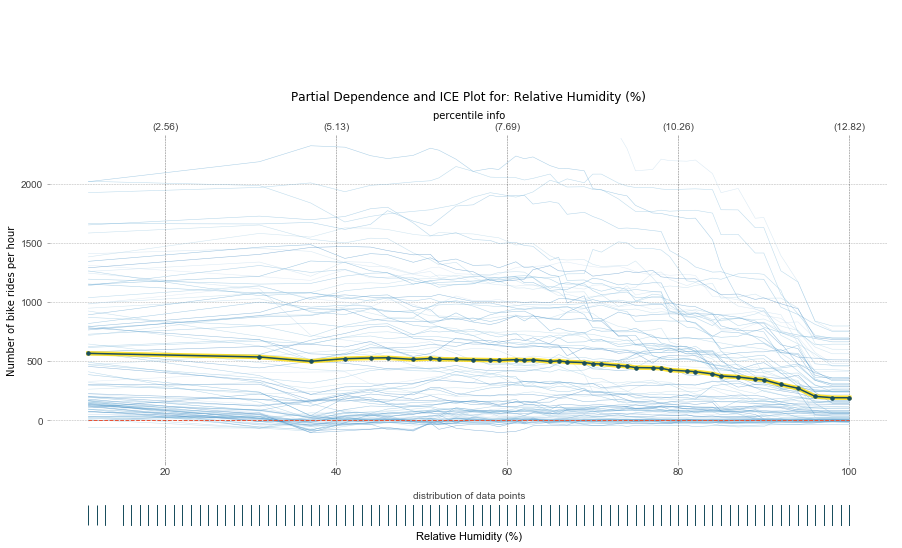

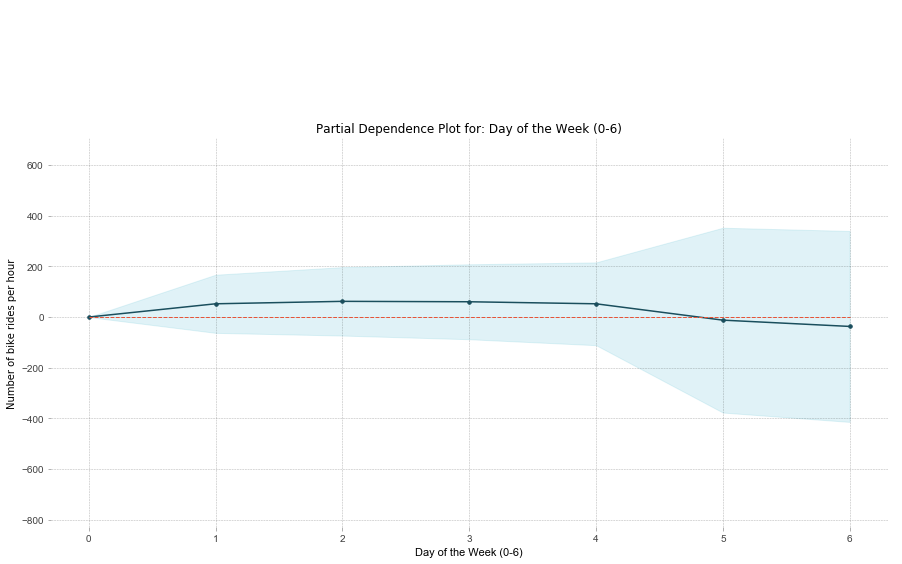

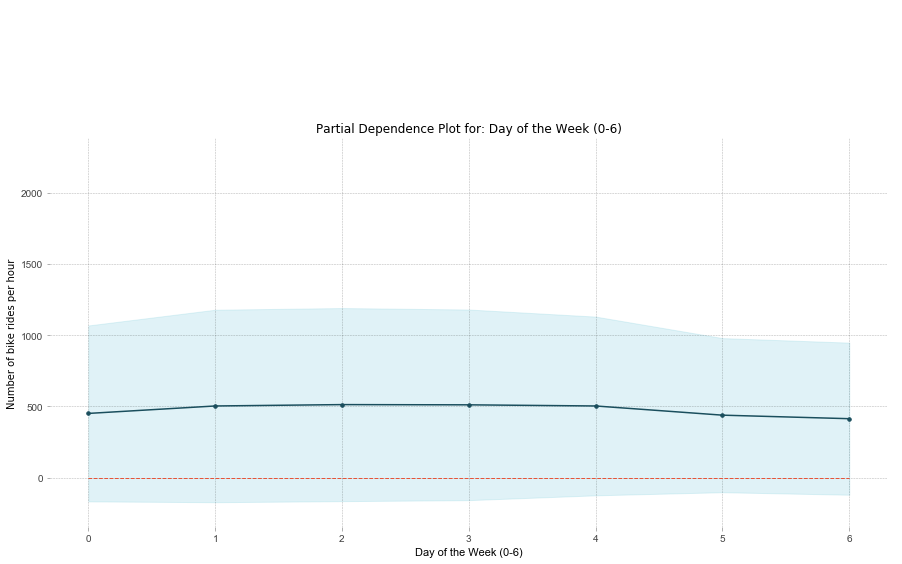

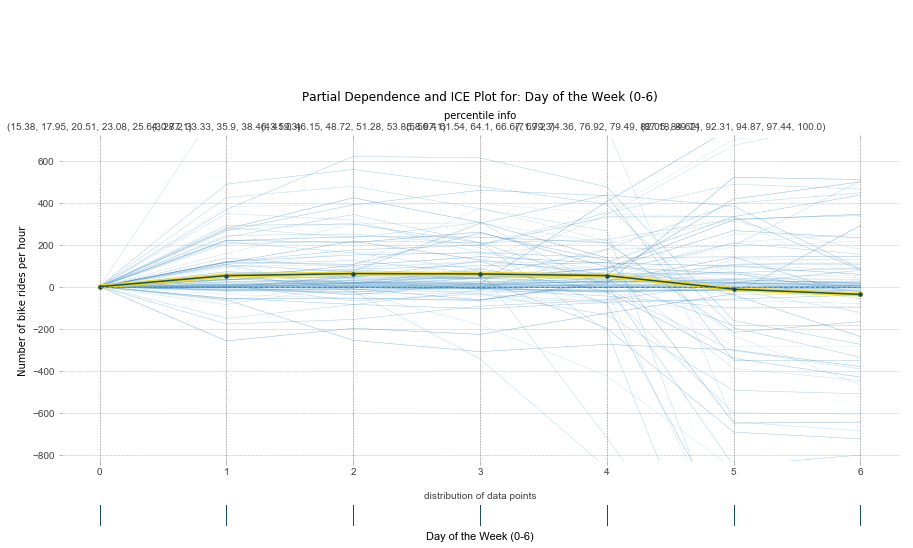

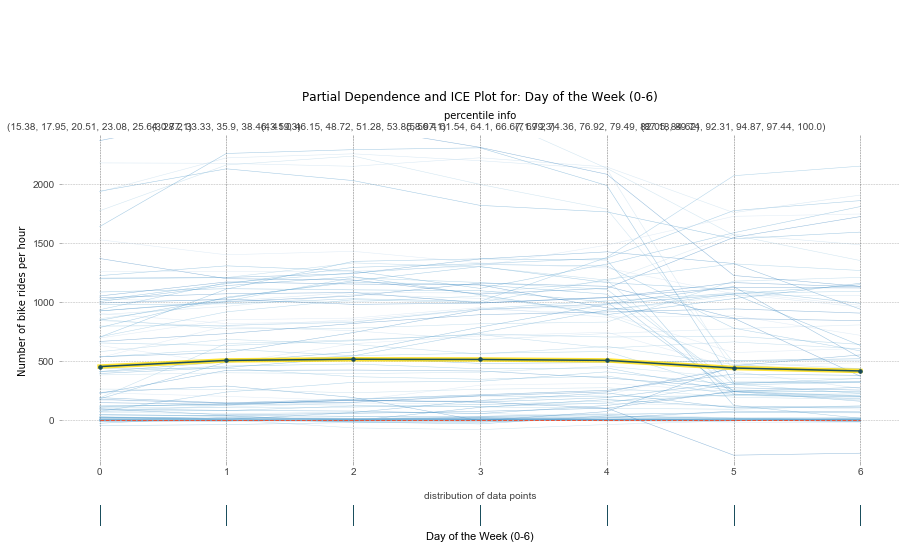

In [44]:
## make and save pdp and ice box plots:
for wch_feature in pdp_plot_features:
    pdp_current, fig_center, fig = construct_pdp(model = mod_this, feature = wch_feature)
    fig_center
    fig

    fig_center, fig = construct_ice_plot(pdp_current, feature = wch_feature)
    fig_center
    fig


### Find out most important interactions

In [45]:
## formula as text for patsy: without interactions
## try all twofold interactions, in order to 
## find important ones via variable importance plots:
formula_interact_txt = target + ' ~ (' + ' + '.join(features) + ') ** 2 - 1'
formula_interact_txt

## create design matrices using patsy (could directly be used for modeling):
#patsy.dmatrix?
dat_interact_y, dat_interact_x = patsy.dmatrices(formula_interact_txt, dat_hr_all, 
                               NA_action = 'drop',
                               return_type = 'dataframe')

## ------------------------------------------------------------------------- ##
## train / test split
## ------------------------------------------------------------------------- ##

## Split the data into training/testing sets (using patsy/dmatrices):
dat_interact_train_x, dat_interact_test_x, dat_interact_train_y, dat_interact_test_y = train_test_split(
    dat_interact_x, dat_interact_y, test_size = 0.1, random_state = 142)

## convert y's to Series (to match data types between patsy and non-patsy data prep:)
dat_interact_train_y = dat_interact_train_y[target]
dat_interact_test_y = dat_interact_test_y[target]

## ------------------------------------------------------------------------- ##
## estimate model and evaluate fit and model assumptions
## ------------------------------------------------------------------------- ##

## Instantiate random forest estimator:
mod_interact_gb = GradientBoostingRegressor(n_estimators = 100, 
                                   random_state = 42,
                                   loss = 'ls',
                                   learning_rate = 0.1,
                                   max_depth = 20, 
                                   min_samples_split = 70,
                                   min_samples_leaf = 30,
                                   verbose = 1)

## Train the model using the training sets:
mod_interact_gb.fit(dat_interact_train_x, dat_interact_train_y)


      Iter       Train Loss   Remaining Time 
         1      339054.6287            2.12m
         2      282015.1249            1.92m
         3      235391.8277            1.81m
         4      197437.2404            2.45m
         5      166537.1038            2.56m
         6      141107.4718            2.46m
         7      119999.3774            2.38m
         8      103008.1605            2.28m
         9       88745.5123            2.18m
        10       77068.8414            2.19m
        20       27266.7401            1.80m
        30       15981.1632            1.47m
        40       11183.2197            1.43m
        50        8412.5629            1.18m
        60        6892.5611           59.59s
        70        6029.6435           43.18s
        80        5418.3944           27.62s
        90        4918.4227           13.26s
       100        4462.8902            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=20, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=30,
             min_samples_split=70, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=1, warm_start=False)

In [46]:
## ------------------------------------------------------------------------- ##
## use and inspect model
## ------------------------------------------------------------------------- ##

## Make predictions using the testing set
dat_interact_test_pred = mod_interact_gb.predict(dat_interact_test_x)
dat_interact_train_pred = mod_interact_gb.predict(dat_interact_train_x)

## Inspect model:
print("MSE in training set = ", mean_squared_error(dat_interact_train_y, dat_interact_train_pred))
print("MSE in test set     = ", mean_squared_error(dat_interact_test_y, dat_interact_test_pred))
print("MAE in training set = ", mean_absolute_error(dat_interact_train_y, dat_interact_train_pred))
print("MAE in test set     = ", mean_absolute_error(dat_interact_test_y, dat_interact_test_pred))
print("R^2 (r squared) in training set = ", r2_score(dat_interact_train_y, dat_interact_train_pred))
print("R^2 (r squared) in test set     = ", r2_score(dat_interact_test_y, dat_interact_test_pred))


MSE in training set =  4462.890204987139
MSE in test set     =  27275.039724621434
MAE in training set =  35.233734021733994
MAE in test set     =  85.33473071370847
R^2 (r squared) in training set =  0.9890977867656442
R^2 (r squared) in test set     =  0.9335588780598212


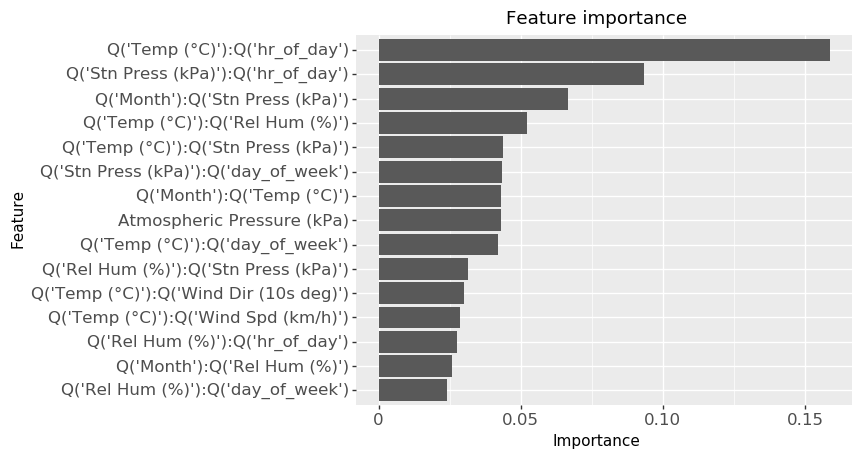

<ggplot: (-9223372029308095393)>


In [47]:
## ========================================================================= ##
## variable importance (interactions)
## ========================================================================= ##

## variable importance:
var_interact_imp = pd.DataFrame(
    {'varname_q'   : dat_interact_train_x.columns,   ## quoted
     'varname_orig'   : [i[3:-2] for i in dat_interact_train_x.columns], 
    'importance' : list(mod_interact_gb.feature_importances_)})
dat_interact_varnames_long = pd.DataFrame.from_dict(varnames_long_dict, orient = 'index', columns = ['varname'])
var_interact_imp = pd.merge(var_interact_imp, dat_interact_varnames_long, 
                   left_on = 'varname_q', right_index = True, 
                   how = 'left')
## for missing "varnames" (not defined in dat_varnames_long, e.g., interactions),
## use varname_q instead:
var_interact_imp['varname'] = np.where(pd.isnull(var_interact_imp['varname']), 
                                        var_interact_imp['varname_q'], var_interact_imp['varname'])
var_interact_imp.sort_values('importance', ascending = False, inplace = True)
var_interact_imp.head(n = 15)
#print(var_imp[['varname', 'importance']].head(n = 15))

## sort variables by importance for plotting:
varname_interact_list = list(var_interact_imp.sort_values('importance')['varname'])
varname_interact_cat = CategoricalDtype(categories = varname_interact_list, ordered=True)
var_interact_imp['varname_cat'] = \
    var_interact_imp['varname'].astype(str).astype(varname_interact_cat)

## plot variable importance (15 most important):
p = ggplot(var_interact_imp[:15], aes(y = 'importance', x = 'varname_cat')) + \
    geom_bar(stat = 'identity') + \
    labs(
        title = "Feature importance",
        x = "Feature",
        y = "Importance") + \
    coord_flip() + \
    theme(axis_text = element_text(size = 12))
print(p)

In [48]:
## ========================================================================= ##
## partial dependence plots: interactions
## ========================================================================= ##

plot_params_pdp_int_default = {
            # plot title and subtitle
            'title': '',
            'subtitle': '',
            'title_fontsize': 15,
            'subtitle_fontsize': 12,
            # color for contour line
            'contour_color':  'white',
            'font_family': 'Arial',
            # matplotlib color map for interact plot
            'cmap': 'viridis',
            # fill alpha for interact plot
            'inter_fill_alpha': 0.8,
            # fontsize for interact plot text
            'inter_fontsize': 9,
        }

def construct_pdp_interact(model, feature_names,
                          dataset_x = dat_train_x, dataset_y = dat_train_y,
                          num_grid_points = num_grid_points_int, n_jobs = n_jobs,
                          model_features = dat_train_x.columns):
    inter_current = pdp.pdp_interact(
        model = model, dataset = dataset_x.join(dataset_y),
        num_grid_points = num_grid_points, n_jobs = n_jobs, ## needs to be 1 for XGBoost model!
        model_features = model_features, features = feature_names)
    fig, axes = pdp.pdp_interact_plot(
        inter_current, feature_names = feature_names, x_quantile = False, 
        plot_type = 'contour', plot_pdp = False, 
        plot_params = plot_params_pdp_int_default)
    axes["pdp_inter_ax"].set_xlabel(varnames_long_dict[feature_names[0]])
    axes["pdp_inter_ax"].set_ylabel(varnames_long_dict[feature_names[1]])
    ## [[here]] y-labels!
    axes["pdp_inter_ax"].set_title('Number of bike rides per hour\n(Partial Dependence Plot) for\n{0} and {1}\n'\
                             .format(varnames_long_dict[feature_names[0]], 
                                    varnames_long_dict[feature_names[1]]), 
                             y = 1)

    return fig

def save_pdp_int_plot(fig, features, filename_stump):
    filename_this = filename_out_prefix + filename_stump + \
        pv.sanitize_python_var_name(features[0]) + "--" + \
        pv.sanitize_python_var_name(features[1]) + ".jpg"
    print("Saving ", filename_this)
    fig.savefig(fname = os.path.join(path_out, filename_this), 
                dpi = 150, pad_inches = .025, bbox_inches = "tight")
    return


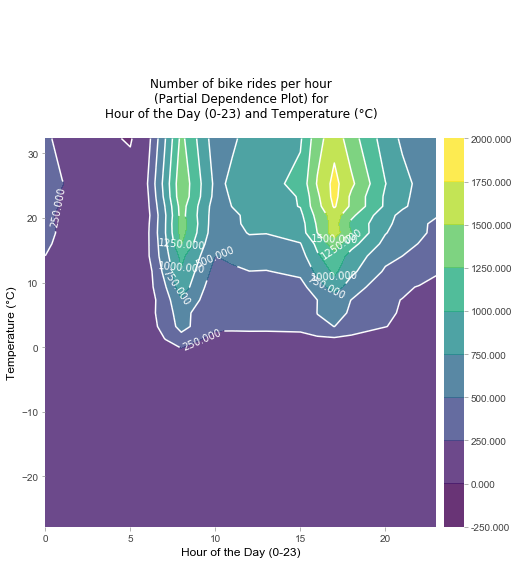

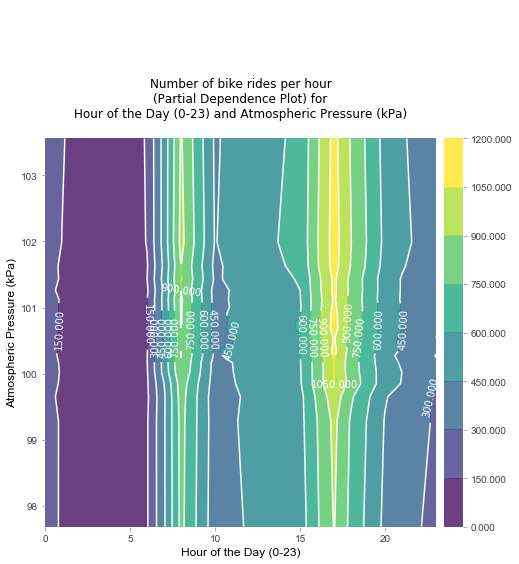

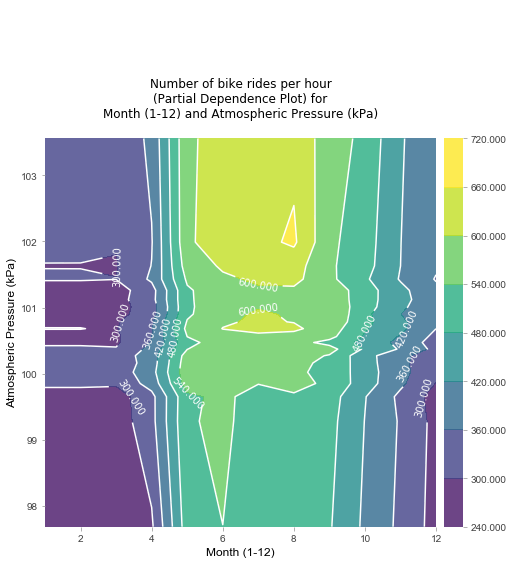

In [49]:
## define feature combinations to plot:
pdp_plot_int_feature_pairs = [
    ["Q('hr_of_day')", "Q('Temp (°C)')", ], 
    ["Q('hr_of_day')", "Q('Stn Press (kPa)')"], 
    ["Q('Month')", "Q('Stn Press (kPa)')"], 
    ["Q('Rel Hum (%)')", "Q('Temp (°C)')"], 
    ["Q('Stn Press (kPa)')", "Q('Temp (°C)')"], 
    ["Q('Stn Press (kPa)')", "Q('day_of_week')"],
    ["Q('hr_of_day')", "Q('day_of_week')"]
]

## make and save pdp interaction plots:
for wch_features in pdp_plot_int_feature_pairs[:3]:
    fig = construct_pdp_interact(model = mod_this, 
                                 #num_grid_points = [4, 4], 
                                 feature_names = wch_features)
    fig



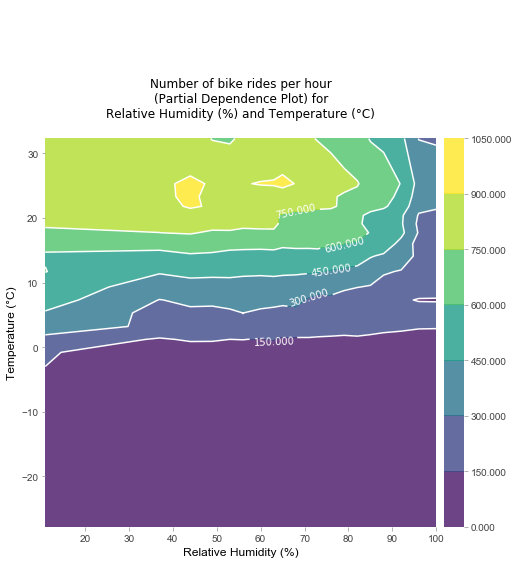

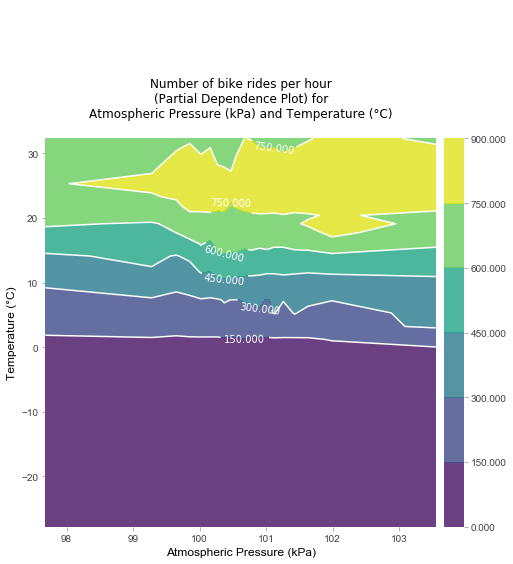

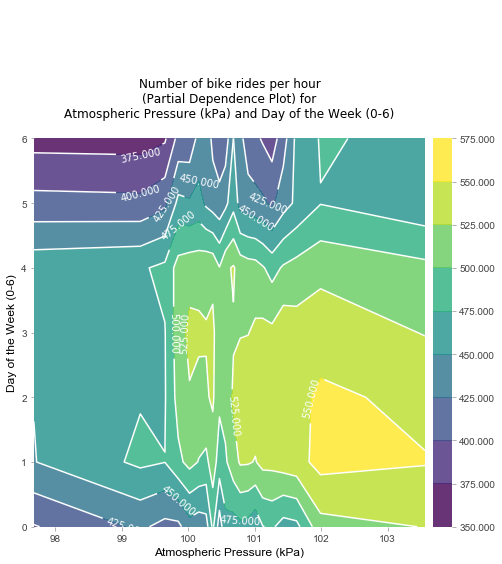

In [50]:
## make and save pdp interaction plots:
for wch_features in pdp_plot_int_feature_pairs[3:6]:
    fig = construct_pdp_interact(model = mod_this, 
                                 #num_grid_points = [4, 4], 
                                 feature_names = wch_features)
    fig

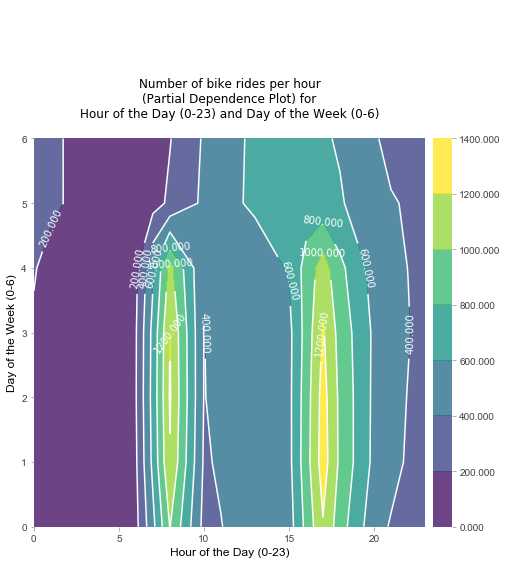

In [51]:
## make and save pdp interaction plots:
for wch_features in pdp_plot_int_feature_pairs[6:]:
    fig = construct_pdp_interact(model = mod_this, 
                                 #num_grid_points = [4, 4], 
                                 feature_names = wch_features)
    fig